In [1]:
import os
import h5py
import glob
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from natsort import natsorted
import matplotlib.pyplot as plt

In [2]:
gm_data = [file for file in glob.glob("data/trained_models/2025-07-23-11/*.csv")]
k5_data = [file for file in (glob.glob("data/trained_models/2025-07-25-14/*.csv"))]

# gm_data = glob.glob("data/trained_models/2025-07-31-10 (GM12878.stranded.ENCFF164VLA.ENCFF074SXQ & K562.stranded.ENCFF336COA.ENCFF829PNJ)/*GM12878*.csv")
# k5_data = glob.glob("data/trained_models/2025-07-31-10 (GM12878.stranded.ENCFF164VLA.ENCFF074SXQ & K562.stranded.ENCFF336COA.ENCFF829PNJ)/*K562*.csv")

In [3]:
data = natsorted(gm_data + k5_data)
cage = pd.read_csv("data/RNA_CAGE.txt", sep="\t")
gm_h5 = h5py.File("data/EPInformer/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5")
k5_h5 = h5py.File("data/EPInformer/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5")

In [4]:
gm_cage = cage[["ENSID", "GM12878_CAGE_128*3_sum"]]
k5_cage = cage[["ENSID", "K562_CAGE_128*3_sum"]]

In [5]:
def decode_and_plot(ensid_folds, h5):
    # Grabs the rows that match the condition we set (negative predictions, error threshold, etc).
    ensid, folds = zip(*ensid_folds)
    bool_df = [gene.decode() in ensid for gene in h5["ensid"]]
    rna_signals = h5["rna"][:][bool_df]

    # Only look at the genes that have a signal.
    filtered_0s = rna_signals[np.any(rna_signals != 0, axis = 1)]
    signal_index = np.where(np.any(rna_signals != 0, axis = 1))[0]
    only_0s_index = np.where(np.all(rna_signals == 0, axis = 1))[0]
    tss_signal = [gene.decode() for gene in h5["ensid"][:][signal_index]]
    tss_no_signal = [gene.decode() for gene in h5["ensid"][:][only_0s_index]]

    print(f"Total Number of Matches: {len(rna_signals)}")
    print(f"Total Matches with >= 1 Non-Zero Value: {len(filtered_0s)}")
    print(f"Percentage of TSSs with No Signal: {(len(rna_signals) - len(filtered_0s)) / len(rna_signals) * 100:.2f}%")

    print(f"Genes w/ Signal: {tss_signal}")
    print(f"Genes w/o Signal: {tss_no_signal}")

    for signal in filtered_0s:
        plt.plot(signal)
    
    return signal_index, only_0s_index

In [6]:
def test_thresholds(dict, h5, conditional_column, thresholds, operand, path, cell_line):
    # Grab the ENSIDs that fit our condition.
    ensid_matches = None
    fold_matches = None
    for threshold in thresholds:
        if operand == "g":
            ensid_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] > threshold].iloc[:, 3])
        elif operand == "ge":
            ensid_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] >= threshold].iloc[:, 3])
        elif operand == "l":
            ensid_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] < threshold].iloc[:, 3])
        elif operand == "le":
            ensid_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] <= threshold].iloc[:, 3])
        elif operand == "eq":
            ensid_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 0])
            fold_matches = list(dict[dict[conditional_column] == threshold].iloc[:, 3])

        print(f"Threshold: {threshold}")
        print("Genes per Fold: ")
        for i, c in pd.Series(fold_matches).value_counts().sort_index().items():
            print(f"{i}: {c}")
        signal_index, only_0s_index = decode_and_plot(zip(ensid_matches, fold_matches), h5)
        plt.savefig(f"{path}/{cell_line}.png")
        plt.show()
        # plt.clf()

        return signal_index, only_0s_index

In [7]:
results_dict = {}
results_dict["GM12878"] = pd.DataFrame()
results_dict["K562"] = pd.DataFrame()
for file in data:
    df = pd.read_csv(file)
    if file[file.find("transform") + 10] == "G":
        results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    else:
        results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

    # if "GM12878" in file:
    #     results_dict["GM12878"] = pd.concat([results_dict["GM12878"], df], ignore_index=True)
    # else:
    #     results_dict["K562"] = pd.concat([results_dict["K562"], df], ignore_index=True)

results_dict["GM12878"] = results_dict["GM12878"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)
results_dict["K562"] = results_dict["K562"].merge(gm_cage, left_on="Unnamed: 0", right_on="ENSID").drop("ENSID", axis=1)

print(f"Num Rows (GM12878): {len(results_dict["GM12878"])}")
print(f"Num Rows (K562): {len(results_dict["K562"])}")

Num Rows (GM12878): 28357
Num Rows (K562): 28357


In [8]:
for key in results_dict.keys():
    print(f"{key}: ")
    results_dict[key]["Error"] = abs(results_dict[key]["Pred"] - results_dict[key]["actual"])
    results_dict[key]["Signed Error"] = results_dict[key]["Pred"] - results_dict[key]["actual"]

    print(f"Mean Error per Fold:\n{results_dict[key].groupby("fold_idx")["Error"].mean()}")

    print(f"\nMax Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().max()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmax()}")

    print(f"\nMin Error Fold: {results_dict[key].groupby("fold_idx")["Error"].mean().min()} at Fold {results_dict[key].groupby("fold_idx")["Error"].mean().idxmin()}")

    print(f"\nMean Error: {results_dict[key]["Error"].mean()}")

    print(f"\nMax Error: {results_dict[key]["Error"].max()}")

    print(f"\nMin Error: {results_dict[key]["Error"].min()} \n")

gm = results_dict["GM12878"]
k5 = results_dict["K562"]

GM12878: 
Mean Error per Fold:
fold_idx
1     0.487524
2     0.450801
3     0.467099
4     0.410750
5     0.520842
6     0.488936
7     0.474234
8     0.479356
9     0.442097
10    0.471362
11    0.443849
12    0.472490
Name: Error, dtype: float64

Max Error Fold: 0.5208424177051227 at Fold 5

Min Error Fold: 0.41074973751623667 at Fold 4

Mean Error: 0.4689510406359734

Max Error: 4.7232875199999995

Min Error: 1.399999999995849e-05 

K562: 
Mean Error per Fold:
fold_idx
1     0.490137
2     0.497488
3     0.460478
4     0.431709
5     0.496517
6     0.494608
7     0.491097
8     0.499403
9     0.479435
10    0.510080
11    0.491731
12    0.509476
Name: Error, dtype: float64

Max Error Fold: 0.5100804644149064 at Fold 10

Min Error Fold: 0.4317085177459157 at Fold 4

Mean Error: 0.49039611933015653

Max Error: 4.80842363

Min Error: 3.740000000007626e-05 



In [9]:
gm["Pred"].min()

np.float64(-0.024230719)

Negative Predictions

GM12878: 
Threshold: 0
Genes per Fold: 
4: 16
Total Number of Matches: 16
Total Matches with >= 1 Non-Zero Value: 1
Percentage of TSSs with No Signal: 93.75%
Genes w/ Signal: ['ENSG00000225630']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2']


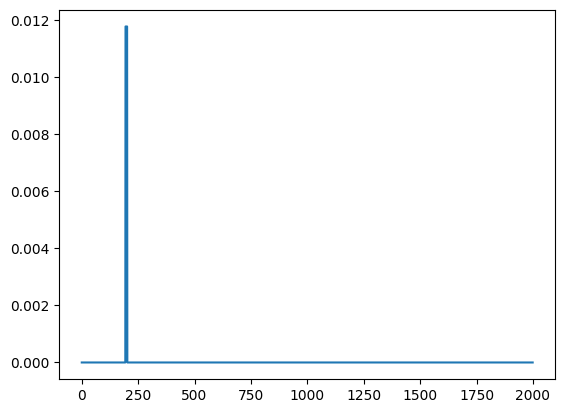

K562: 
Threshold: 0
Genes per Fold: 
3: 105
4: 10
8: 1
10: 1
Total Number of Matches: 117
Total Matches with >= 1 Non-Zero Value: 44
Percentage of TSSs with No Signal: 62.39%
Genes w/ Signal: ['ENSG00000225630', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000242485', 'ENSG00000205116', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197530', 'ENSG00000189409', 'ENSG00000189339', 'ENSG00000008130', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000187730', 'ENSG00000067606_1', 'ENSG00000162585', 'ENSG00000157933', 'ENSG00000157933_1', 'ENSG00000157870', 'ENSG00000116213', 'ENSG00000078900', 'ENSG00000078900_1', 'ENSG00000293478', 'ENSG00000162592', 'ENSG00000235169

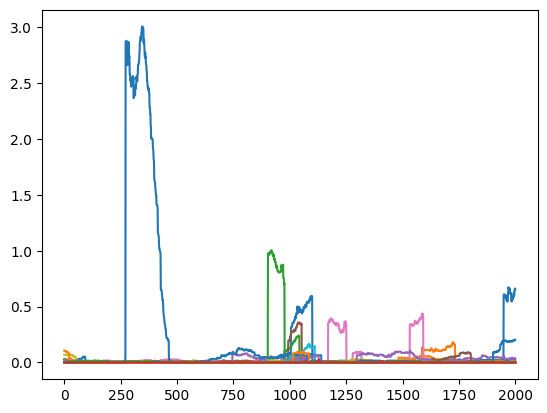

In [10]:
print("GM12878: ")
gm_neg_pred_signal, gm_neg_pred_no_signal = test_thresholds(gm, gm_h5, "Pred", [0], "l", "predictions/2025-07-23-25/neg_preds", "GM12878")

print("K562: ")
k5_neg_pred_signal, k5_neg_pred_no_signal = test_thresholds(k5, k5_h5, "Pred", [0], "l", "predictions/2025-07-23-25/neg_preds", "K562")

Low Errors

In [11]:
gm["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.007918
0.05    0.040805
0.10    0.073478
Name: Error, dtype: float64

In [12]:
k5["Error"].quantile([0.01, 0.05, 0.1])

0.01    0.007989
0.05    0.034364
0.10    0.061697
Name: Error, dtype: float64

GM12878: 
Threshold: 0.001
Genes per Fold: 
1: 2
2: 9
3: 3
4: 6
5: 2
6: 4
7: 1
8: 3
9: 2
10: 3
11: 5
12: 3
Total Number of Matches: 43
Total Matches with >= 1 Non-Zero Value: 23
Percentage of TSSs with No Signal: 46.51%
Genes w/ Signal: ['ENSG00000225630', 'ENSG00000229344', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000160087', 'ENSG00000127054', 'ENSG00000169962', 'ENSG00000162576']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000162571_1', 'ENSG00000186827', 'ENSG00000184163', 'ENSG000001

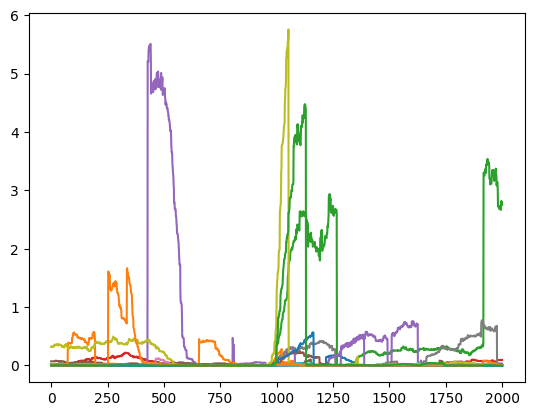

K562: 
Threshold: 0.001
Genes per Fold: 
1: 1
2: 3
3: 2
4: 3
5: 3
6: 3
7: 4
8: 2
10: 3
11: 1
12: 2
Total Number of Matches: 27
Total Matches with >= 1 Non-Zero Value: 10
Percentage of TSSs with No Signal: 62.96%
Genes w/ Signal: ['ENSG00000229344', 'ENSG00000198744', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000187634', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000237330']
Genes w/o Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000240409', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187642', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000131591']


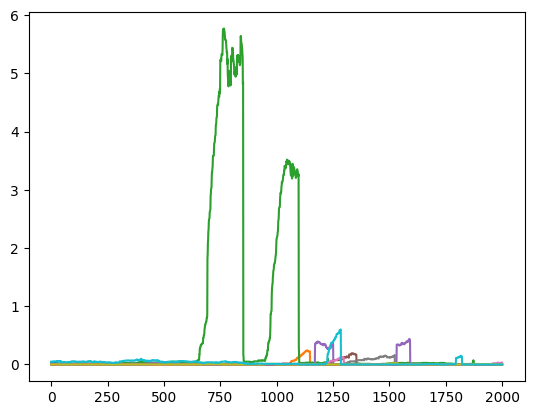

In [13]:
print("GM12878: ")
gm_low_error_signal, gm_low_error_no_signal = test_thresholds(gm, gm_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/2025-07-23-25/low_errors", "GM12878")

print("K562: ")
k5_low_error_signal, k5_low_error_no_signal = test_thresholds(k5, k5_h5, "Error", [0.001, 0.01, 0.1], "l", "predictions/2025-07-23-25/low_errors", "K562")

High Errors

In [14]:
gm["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.029975
0.95    1.418183
0.99    2.301041
Name: Error, dtype: float64

In [15]:
k5["Error"].quantile([0.9, 0.95, 0.99])

0.90    1.149304
0.95    1.612229
0.99    2.410188
Name: Error, dtype: float64

GM12878: 
Threshold: 1
Genes per Fold: 
1: 317
2: 267
3: 202
4: 137
5: 276
6: 248
7: 198
8: 297
9: 269
10: 307
11: 215
12: 279
Total Number of Matches: 3012
Total Matches with >= 1 Non-Zero Value: 2573
Percentage of TSSs with No Signal: 14.58%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000272438', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENS

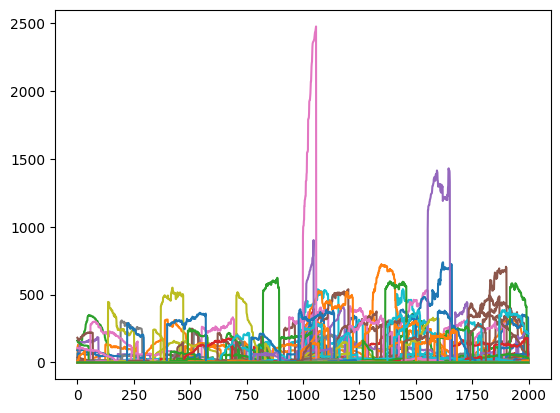

K562: 
Threshold: 1
Genes per Fold: 
1: 357
2: 330
3: 247
4: 175
5: 275
6: 251
7: 247
8: 345
9: 322
10: 426
11: 281
12: 357
Total Number of Matches: 3613
Total Matches with >= 1 Non-Zero Value: 3048
Percentage of TSSs with No Signal: 15.64%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000162571_1', 'ENSG00000186891', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000127054', 'ENSG00000224051', 'ENSG00000169962', 'ENSG00000107404', 'ENSG0000

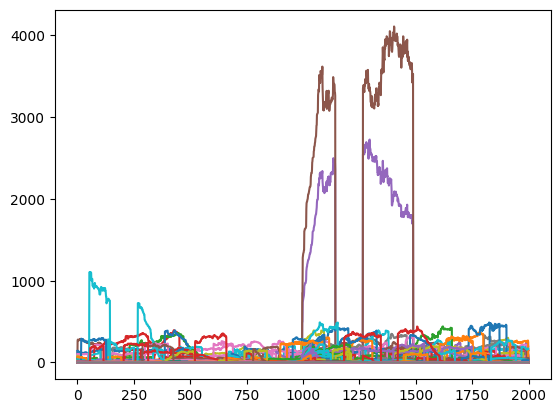

In [16]:
print("GM12878: ")
gm_high_error_signal, gm_high_error_no_signal = test_thresholds(gm, gm_h5, "Error", [1, 1.5, 2], "g", "predictions/2025-07-23-25/high_errors", "GM12878")

print("K562: ")
k5_high_error_signal, k5_high_error_no_signal = test_thresholds(k5, k5_h5, "Error", [1, 1.5, 2], "g", "predictions/2025-07-23-25/high_errors", "K562")

Overestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1086
2: 1120
3: 858
4: 822
5: 659
6: 886
7: 1155
8: 1420
9: 1143
10: 1319
11: 1152
12: 1269
Total Number of Matches: 12889
Total Matches with >= 1 Non-Zero Value: 8934
Percentage of TSSs with No Signal: 30.69%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000228794_2', 'ENSG00000187634_1', 'ENSG00000187634_2', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000187608', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571_1', 'ENSG00000176022', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000169962', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000160072', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000272106', 'ENSG000000081

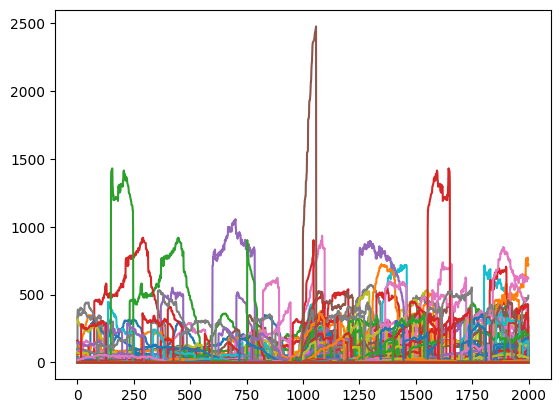

K562
Threshold: 0
Genes per Fold: 
1: 974
2: 789
3: 980
4: 378
5: 773
6: 694
7: 865
8: 991
9: 1007
10: 1214
11: 712
12: 1104
Total Number of Matches: 10481
Total Matches with >= 1 Non-Zero Value: 7581
Percentage of TSSs with No Signal: 27.67%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000228794', 'ENSG00000225880', 'ENSG00000228794_1', 'ENSG00000187634', 'ENSG00000187634_2', 'ENSG00000188976', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187608', 'ENSG00000188157', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG0000

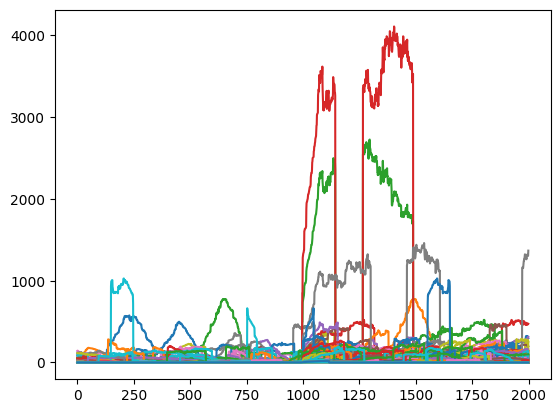

In [17]:
print("GM12878: ")
gm_over_signal, gm_over_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "l", "predictions/2025-07-23-25/overestimates", "GM12878")

print("K562")
k5_over_signal, k5_over_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "l", "predictions/2025-07-23-25/overestimates", "K562")

Underestimates

GM12878: 
Threshold: 0
Genes per Fold: 
1: 1700
2: 1473
3: 1079
4: 767
5: 1664
6: 1103
7: 934
8: 1182
9: 1355
10: 1673
11: 1107
12: 1431
Total Number of Matches: 15468
Total Matches with >= 1 Non-Zero Value: 8938
Percentage of TSSs with No Signal: 42.22%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000272438', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000187961', 'ENSG00000187583', 'ENSG00000187642', 'ENSG00000188290', 'ENSG00000291156', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000127054', 'ENSG00000224051_1', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000189339', 'ENSG00000008128', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000169885',

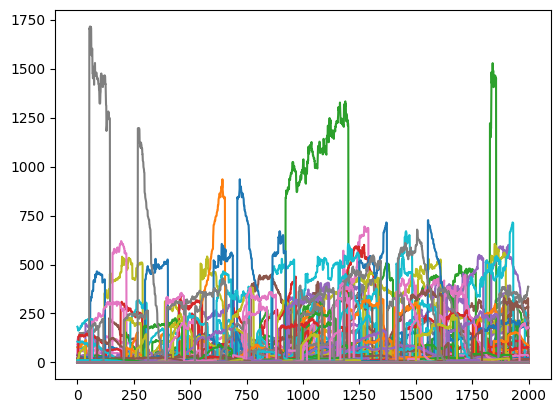

K562
Threshold: 0
Genes per Fold: 
1: 1812
2: 1804
3: 957
4: 1211
5: 1550
6: 1295
7: 1224
8: 1611
9: 1491
10: 1778
11: 1547
12: 1596
Total Number of Matches: 17876
Total Matches with >= 1 Non-Zero Value: 10510
Percentage of TSSs with No Signal: 41.21%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000198744', 'ENSG00000237491', 'ENSG00000228794', 'ENSG00000223764', 'ENSG00000187634', 'ENSG00000187634_1', 'ENSG00000188976', 'ENSG00000187583', 'ENSG00000187608', 'ENSG00000304119', 'ENSG00000237330', 'ENSG00000131591', 'ENSG00000162571', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000184163', 'ENSG00000160087', 'ENSG00000131584', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000228594', 'ENSG00000197530', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG00000078369_1', 'ENSG00000178821', 'ENSG00000142609', 

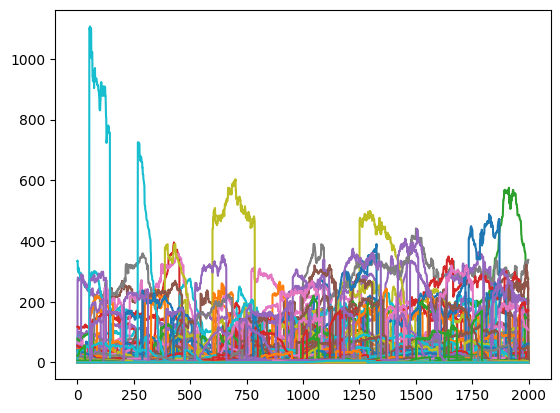

In [18]:
print("GM12878: ")
gm_under_signal, gm_under_no_signal = test_thresholds(gm, gm_h5, "Signed Error", [0], "g", "predictions/2025-07-23-25/underestimates", "GM12878")

print("K562")
k5_under_signal, k5_under_no_signal = test_thresholds(k5, k5_h5, "Signed Error", [0], "g", "predictions/2025-07-23-25/underestimates", "K562")

Worst Errors (Over Expressed)

In [19]:
n = 5

In [20]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Signed Error"] = pd.to_numeric(over_df_gm["Signed Error"])
    over_df_5_worst_gm = over_df_gm.nlargest(n, columns=["Signed Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Signed Error"] = pd.to_numeric(over_df_k5["Signed Error"])
    over_df_5_worst_k5 = over_df_k5.nlargest(n, columns=["Signed Error"])

print("GM12878: ")
display(over_df_5_worst_gm)

print("K562: ")
display(over_df_5_worst_k5)

GM12878: 


Unnamed: 0      Pred  actual  fold_idx  GM12878_CAGE_128*3_sum  \
10600  ENSG00000100804  3.837597     0.0         5                     NaN   
816    ENSG00000176261  3.259053     0.0         1                     NaN   
2405   ENSG00000126067  3.257822     0.0         1                     NaN   
2427   ENSG00000160049  3.074574     0.0         1                     NaN   
1570   ENSG00000132485  3.050116     0.0         1                     NaN   

          Error  Signed Error  
10600  3.837597      3.837597  
816    3.259053      3.259053  
2405   3.257822      3.257822  
2427   3.074574      3.074574  
1570   3.050116      3.050116

K562: 


Unnamed: 0      Pred  actual  fold_idx  GM12878_CAGE_128*3_sum  \
1198   ENSG00000162851  3.562582     0.0         1                 541.599   
875    ENSG00000117748  3.377295     0.0         1                 881.266   
39     ENSG00000143106  3.359196     0.0         1                2220.680   
16274  ENSG00000213593  3.320452     0.0         8                     NaN   
1125   ENSG00000117697  3.195888     0.0         1                 461.646   

          Error  Signed Error  
1198   3.562582      3.562582  
875    3.377295      3.377295  
39     3.359196      3.359196  
16274  3.320452      3.320452  
1125   3.195888      3.195888

GM12878: 


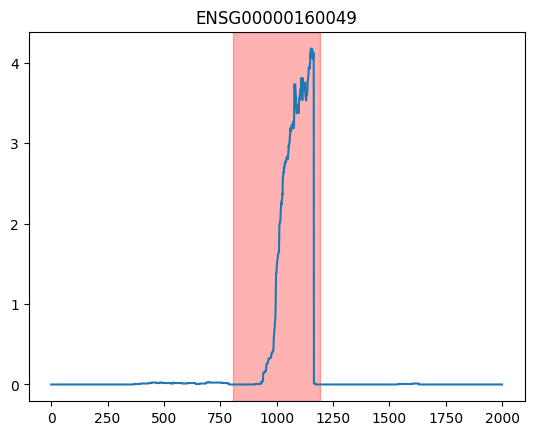

Pred: 3.074574
Actual: 0.0


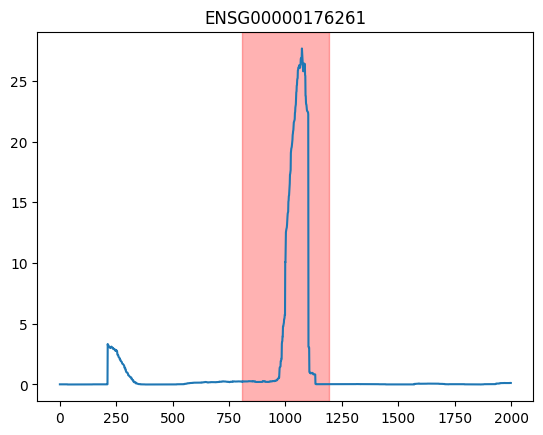

Pred: 3.2590528
Actual: 0.0


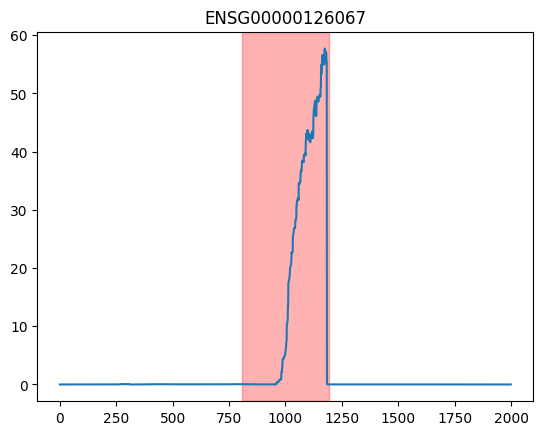

Pred: 3.2578223
Actual: 0.0


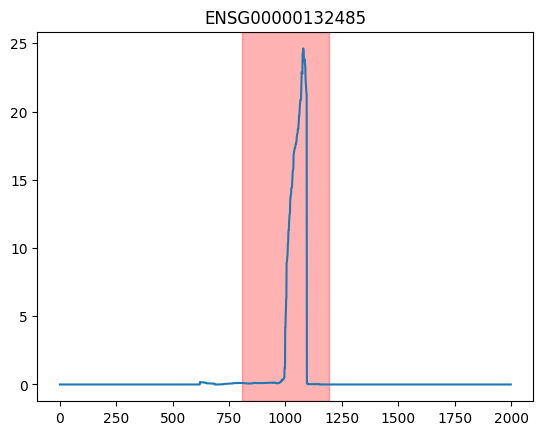

Pred: 3.0501163
Actual: 0.0


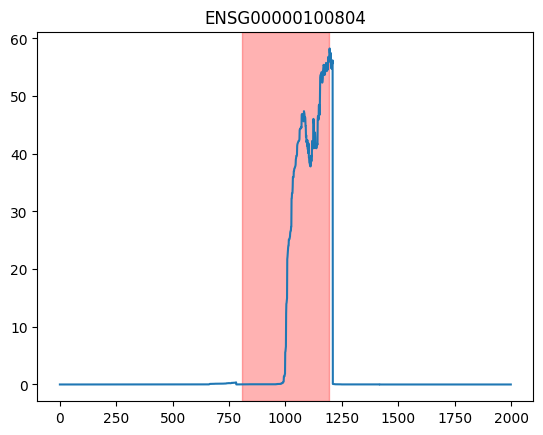

Pred: 3.837597
Actual: 0.0

K562: 


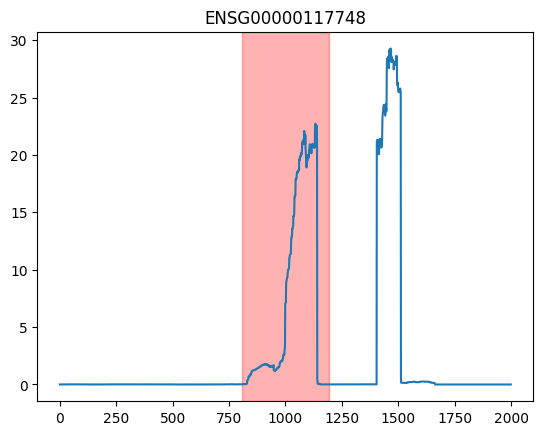

Pred: 3.377295
Actual: 0.0


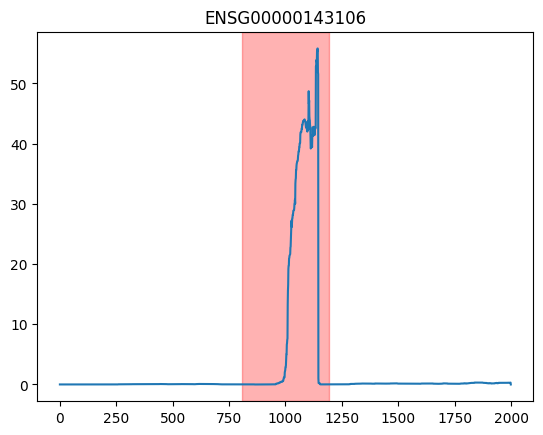

Pred: 3.359196
Actual: 0.0


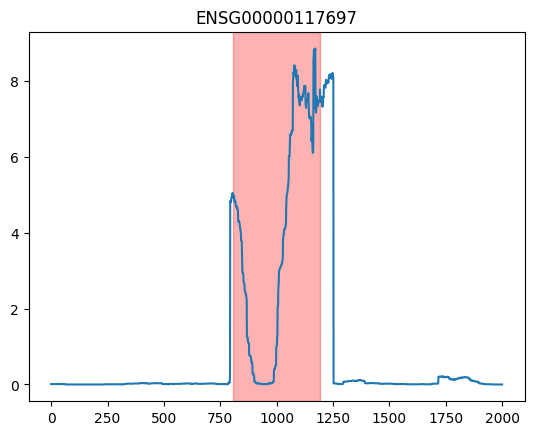

Pred: 3.1958876
Actual: 0.0


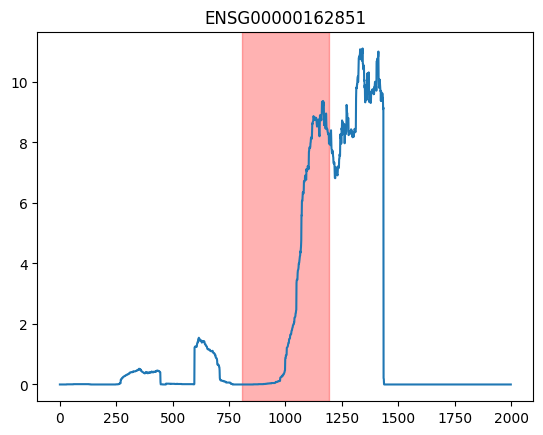

Pred: 3.5625825
Actual: 0.0


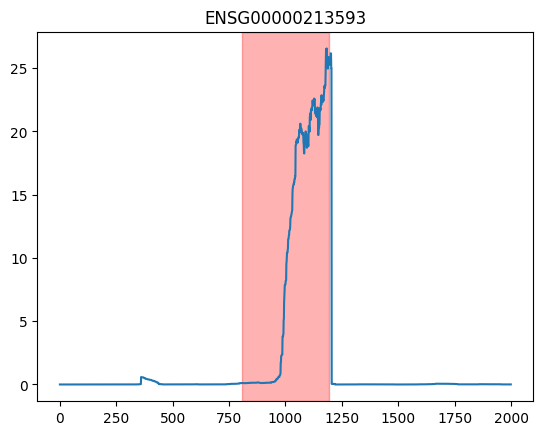

Pred: 3.3204522
Actual: 0.0


In [21]:
# Individual Plots
signal_5_worst_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_worst_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_over_gm):
    plt.plot(signal_5_worst_over_gm[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-23-25/overestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_over_k5):
    plt.plot(signal_5_worst_over_k5[i])
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-23-25/overestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmax()]}")

Worst Errors (Under Expressed)

In [22]:
with pd.option_context("mode.chained_assignment", None):
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Signed Error"] = pd.to_numeric(under_df_gm["Signed Error"])
    under_df_5_worst_gm = under_df_gm.nsmallest(n, columns=["Signed Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Signed Error"] = pd.to_numeric(under_df_k5["Signed Error"])
    under_df_5_worst_k5 = under_df_k5.nsmallest(n, columns=["Signed Error"])

print("GM12878: ")
display(under_df_5_worst_gm)

print("K562: ")
display(under_df_5_worst_k5)

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
18043  ENSG00000202538  1.110486  5.662860         9               460107.00   
25467  ENSG00000272160  0.165033  4.697162        11                49791.30   
19629  ENSG00000200795  0.957539  5.415317         9               260205.00   
16694  ENSG00000199325  0.200666  3.754244         8                 5677.64   
646    ENSG00000199377  0.962247  4.507385         1                32164.10   

          Error  Signed Error  
18043  4.552374     -4.552374  
25467  4.532129     -4.532129  
19629  4.457778     -4.457778  
16694  3.553579     -3.553579  
646    3.545138     -3.545138

K562: 


Unnamed: 0      Pred    actual  fold_idx  GM12878_CAGE_128*3_sum  \
21283  ENSG00000142541  0.945669  4.377945        10                     NaN   
25037  ENSG00000122862  0.448682  3.565910        11                48321.60   
11792  ENSG00000233440  0.222033  3.252559         6                  466.40   
26371  ENSG00000253506  0.261255  3.284126        12                 4388.55   
20342  ENSG00000180574  0.102649  3.124833         9                 1220.50   

          Error  Signed Error  
21283  3.432277     -3.432277  
25037  3.117228     -3.117228  
11792  3.030527     -3.030527  
26371  3.022871     -3.022871  
20342  3.022184     -3.022184

GM12878: 


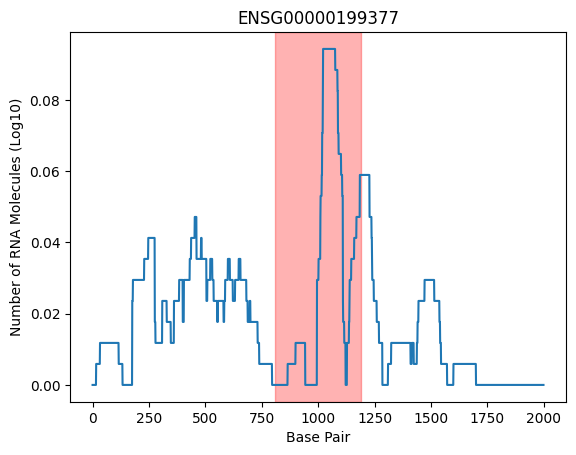

Pred: 0.96224725
Actual: 4.507385


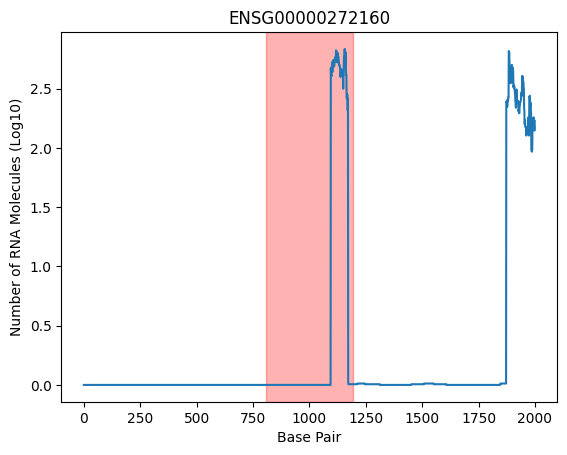

Pred: 0.16503319
Actual: 4.697162


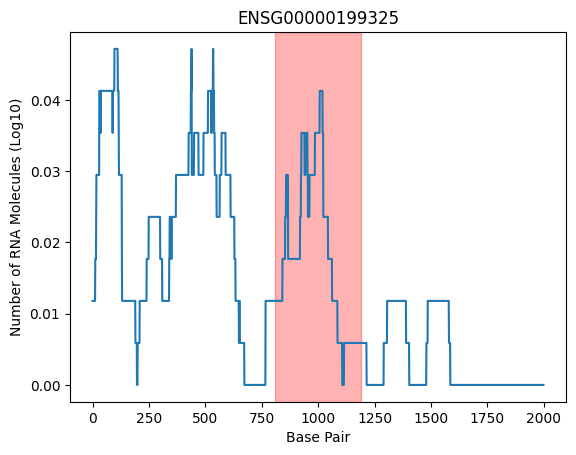

Pred: 0.2006657
Actual: 3.7542443


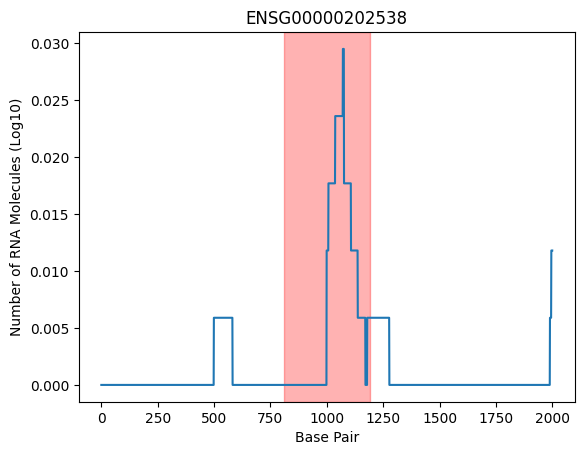

Pred: 1.1104861
Actual: 5.66286


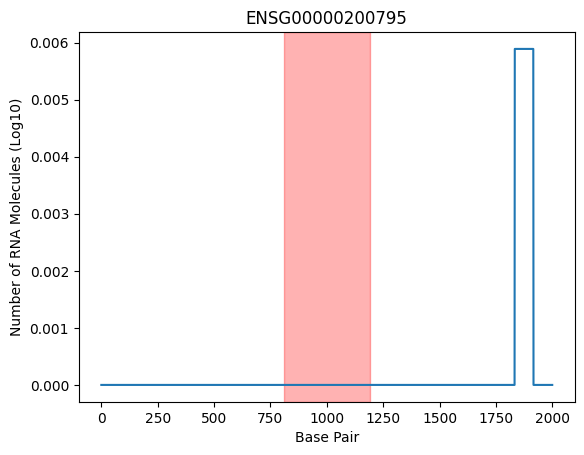

Pred: 0.9575392
Actual: 5.4153175

K562: 


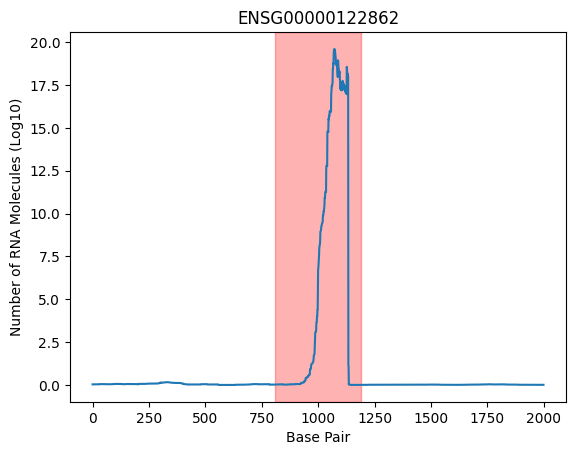

Pred: 0.44868228
Actual: 3.5659103


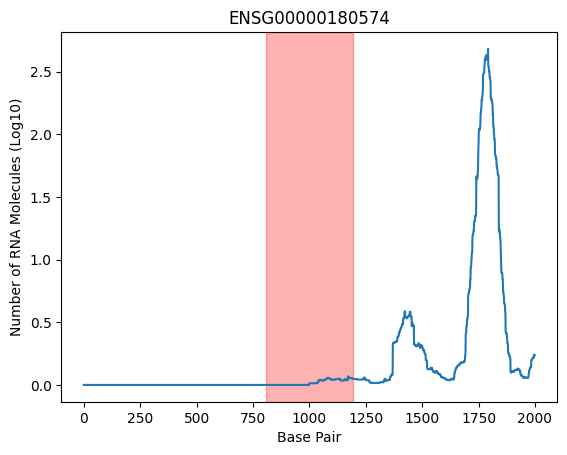

Pred: 0.10264936
Actual: 3.1248333


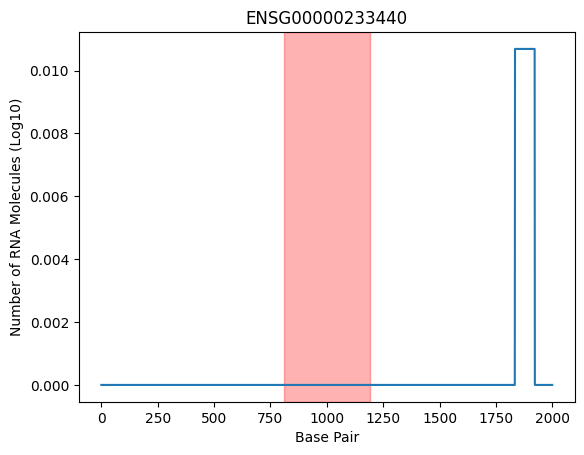

Pred: 0.22203277
Actual: 3.2525594


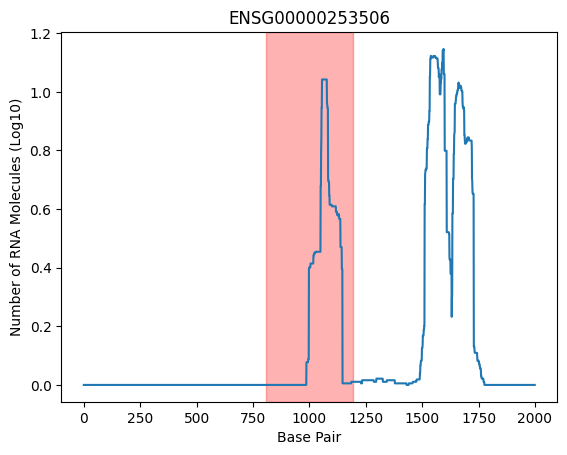

Pred: 0.26125535
Actual: 3.284126


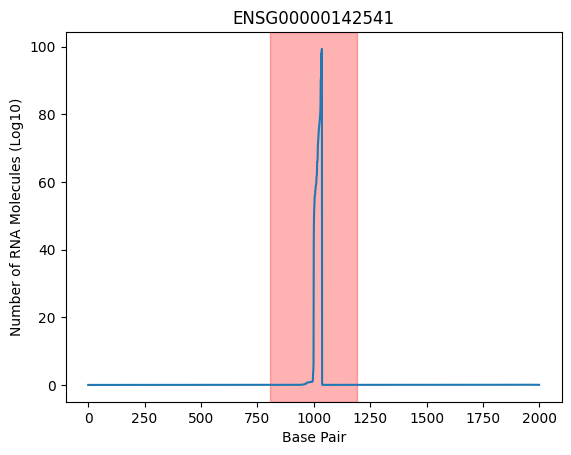

Pred: 0.9456686
Actual: 4.3779454


In [23]:
# Individual Plots
signal_5_worst_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_worst_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_worst_under_gm = 10 ** signal_5_worst_under_gm - 1
# signal_5_worst_under_k5 = 10 ** signal_5_worst_under_k5 - 1

ensid_5_worst_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_worst_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_worst_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_worst_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_worst_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-23-25/underestimates/worst/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_worst_under_k5):
    plt.plot(signal_5_worst_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-23-25/underestimates/worst/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Signed Error"].idxmin()]}")

Best Errors (Over Expressed)

In [24]:
with pd.option_context("mode.chained_assignment", None):
    over_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_over_signal]]
    over_df_gm = gm[gm["Unnamed: 0"].isin(over_ensids_gm)]
    over_df_gm["Error"] = pd.to_numeric(over_df_gm["Error"])
    over_df_5_best_gm = over_df_gm.nsmallest(n, columns=["Error"])

    over_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_over_signal]]
    over_df_k5 = k5[k5["Unnamed: 0"].isin(over_ensids_k5)]
    over_df_k5["Error"] = pd.to_numeric(over_df_k5["Error"])
    over_df_5_best_k5 = over_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(over_df_5_best_gm)

print("K562: ")
display(over_df_5_best_k5)

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
25048    ENSG00000040199  1.994963  1.994977        11   
10316    ENSG00000100448  0.388099  0.388067         5   
24394    ENSG00000103264  2.487153  2.487326        11   
25480    ENSG00000102974  2.835364  2.835043        11   
18212  ENSG00000094914_1  2.933462  2.933811         9   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
25048                97.85000  0.000014     -0.000014  
10316                 1.44381  0.000032      0.000032  
24394               306.13300  0.000174     -0.000174  
25480               682.98000  0.000320      0.000320  
18212               857.64000  0.000349     -0.000349

K562: 


Unnamed: 0      Pred    actual  fold_idx  \
12365  ENSG00000243319_1  1.211982  1.211868         6   
16644    ENSG00000183020  1.955528  1.955851         8   
24854  ENSG00000065809_1  0.653609  0.653155        11   
935      ENSG00000158769  2.902838  2.904061         1   
24261    ENSG00000140694  2.723861  2.722443        11   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
12365                  21.033  0.000114      0.000114  
16644                 162.717  0.000323     -0.000323  
24854                     NaN  0.000455      0.000455  
935                   387.308  0.001223     -0.001223  
24261                 793.241  0.001418      0.001418

GM12878: 


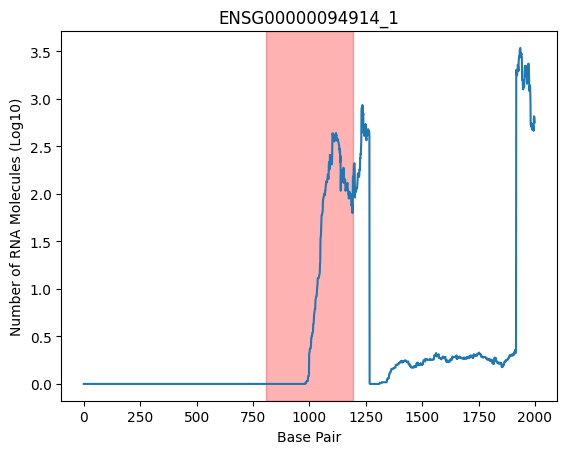

Pred: 2.933462
Actual: 2.9338112


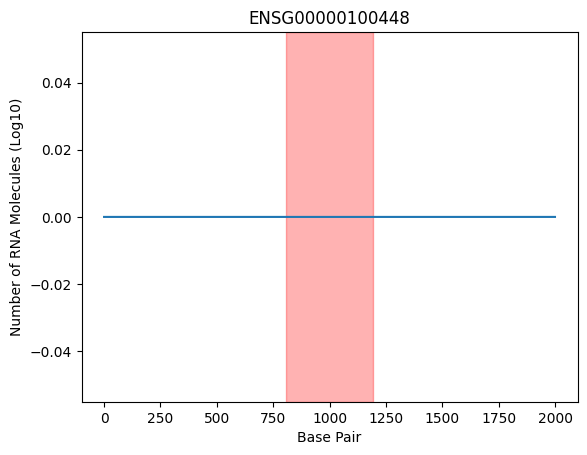

Pred: 0.3880993
Actual: 0.38806742


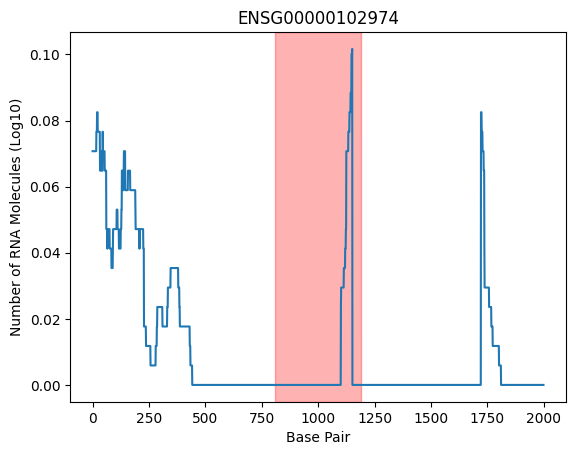

Pred: 2.8353636
Actual: 2.8350434


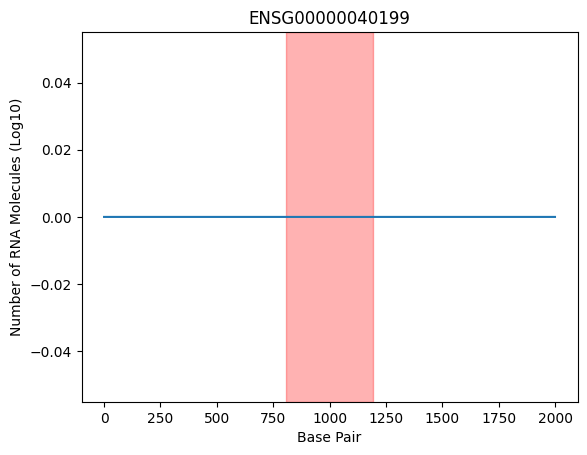

Pred: 1.9949626
Actual: 1.9949766


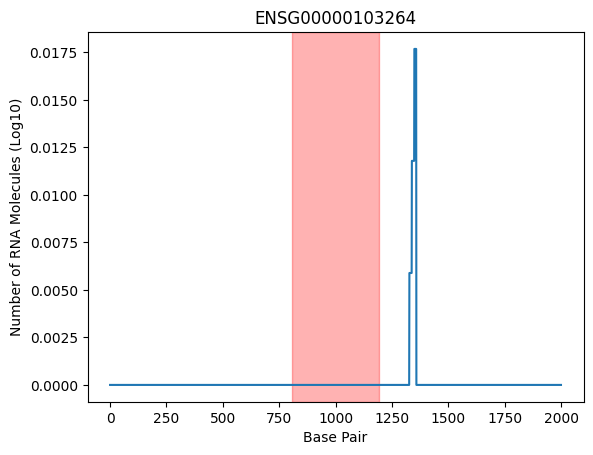

Pred: 2.4871528
Actual: 2.4873264

K562: 


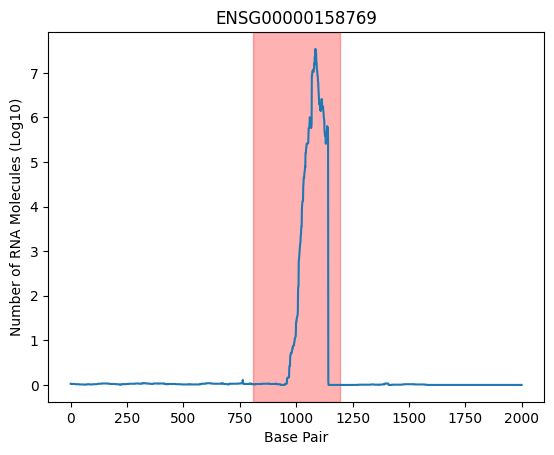

Pred: 2.9028378
Actual: 2.904061


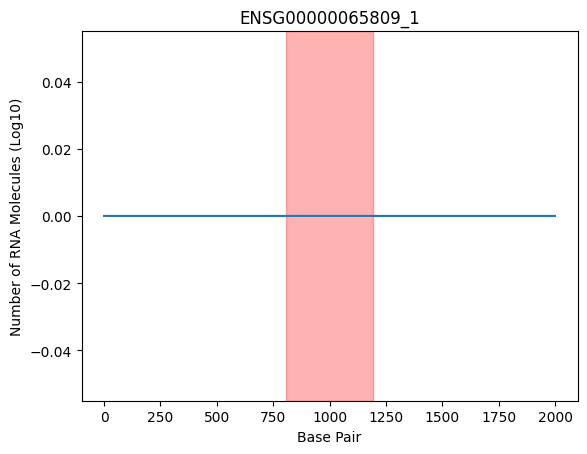

Pred: 0.65360945
Actual: 0.6531546


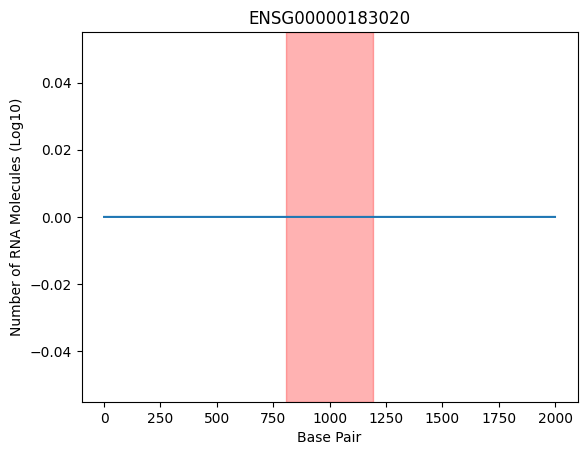

Pred: 1.9555281
Actual: 1.9558512


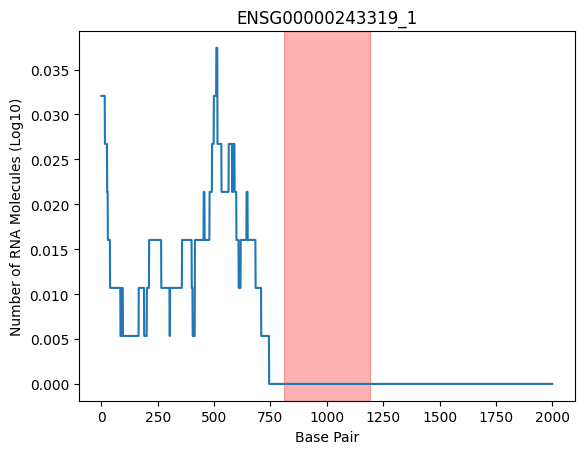

Pred: 1.2119815
Actual: 1.2118678


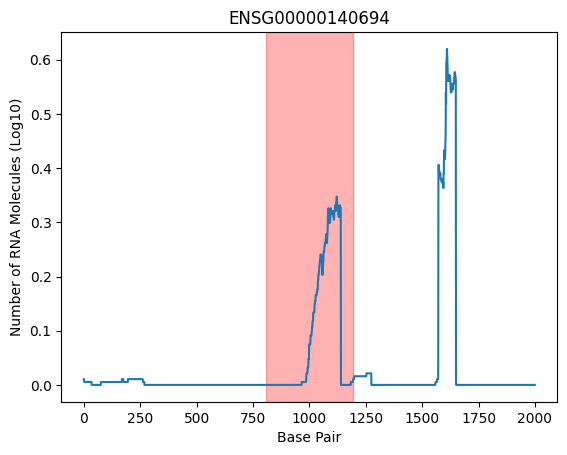

Pred: 2.7238607
Actual: 2.722443


In [25]:
# Individual Plots
signal_5_best_over_gm = gm_h5["rna"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_over_k5 = k5_h5["rna"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

ensid_5_best_over_gm = gm_h5["ensid"][:][[gene.decode() in list(over_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_over_k5 = k5_h5["ensid"][:][[gene.decode() in list(over_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_over_gm):
    plt.plot(signal_5_best_over_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-23-25/overestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_over_k5):
    plt.plot(signal_5_best_over_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-23-25/overestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmax()]}")

Best Errors (Under Expressed)

In [26]:
with pd.option_context("mode.chained_assignment", None): 
    under_ensids_gm = [gene.decode() for gene in gm_h5["ensid"][:][gm_under_signal]]
    under_df_gm = gm[gm["Unnamed: 0"].isin(under_ensids_gm)]
    under_df_gm["Error"] = pd.to_numeric(under_df_gm["Error"])
    under_df_5_best_gm = under_df_gm.nsmallest(n, columns=["Error"])

    under_ensids_k5 = [gene.decode() for gene in k5_h5["ensid"][:][k5_under_signal]]
    under_df_k5 = k5[k5["Unnamed: 0"].isin(under_ensids_k5)]
    under_df_k5["Error"] = pd.to_numeric(under_df_k5["Error"])
    under_df_5_best_k5 = under_df_k5.nsmallest(n, columns=["Error"])

print("GM12878: ")
display(under_df_5_best_gm)

print("K562: ")
display(under_df_5_best_k5) 

GM12878: 


Unnamed: 0      Pred    actual  fold_idx  \
25048    ENSG00000040199  1.994963  1.994977        11   
10316    ENSG00000100448  0.388099  0.388067         5   
4675     ENSG00000134318  2.148365  2.148482         2   
15898  ENSG00000137497_2  1.389320  1.389067         8   
7661   ENSG00000266256_1  0.721748  0.721448         4   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
25048                97.85000  0.000014     -0.000014  
10316                 1.44381  0.000032      0.000032  
4675                139.76100  0.000117     -0.000117  
15898                23.49440  0.000253      0.000253  
7661                  4.26560  0.000300      0.000300

K562: 


Unnamed: 0      Pred    actual  fold_idx  \
5111   ENSG00000077380_1  2.544437  2.544399         2   
4213     ENSG00000135638  1.893482  1.893429         2   
12365  ENSG00000243319_1  1.211982  1.211868         6   
15250  ENSG00000158445_1  1.699484  1.698970         7   
13729    ENSG00000101350  1.942226  1.941427         7   

       GM12878_CAGE_128*3_sum     Error  Signed Error  
5111                  344.854  0.000037      0.000037  
4213                   72.215  0.000053      0.000053  
12365                  21.033  0.000114      0.000114  
15250                  40.263  0.000514      0.000514  
13729                 297.729  0.000799      0.000799

GM12878: 


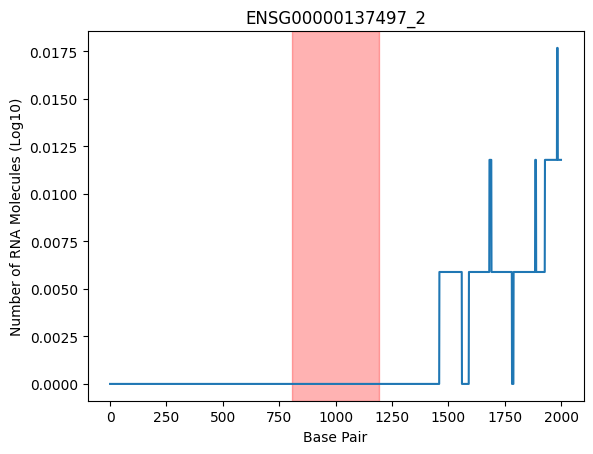

Pred: 1.3893198
Actual: 1.3890668


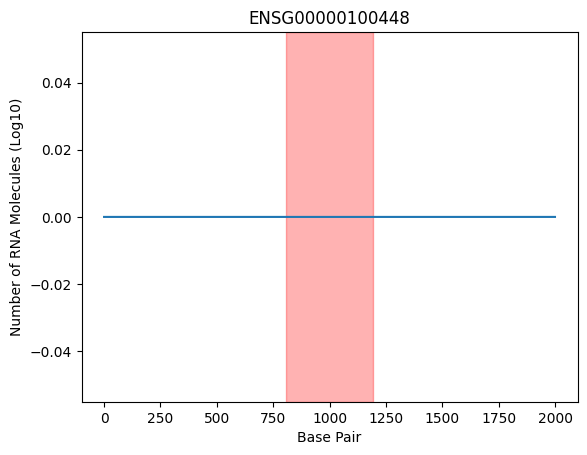

Pred: 0.3880993
Actual: 0.38806742


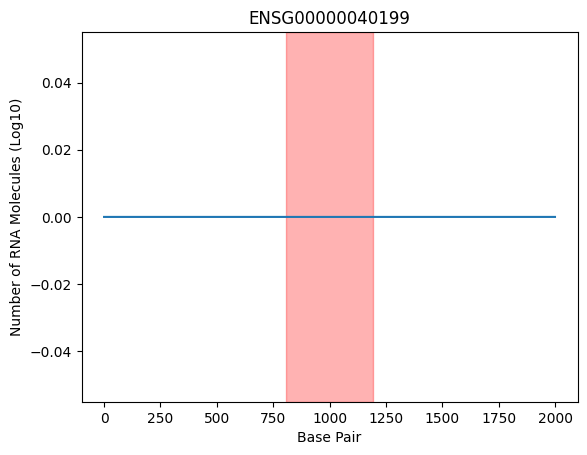

Pred: 1.9949626
Actual: 1.9949766


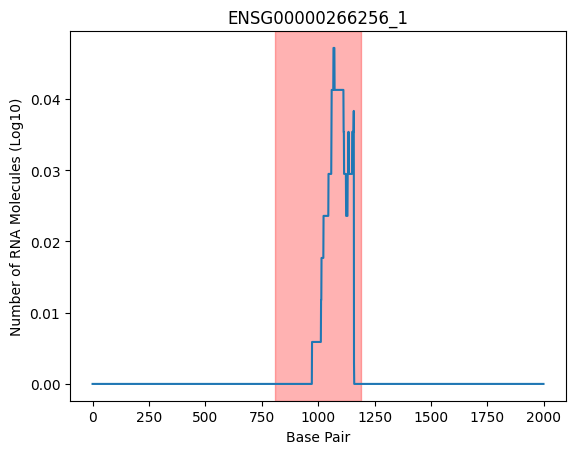

Pred: 0.7217478
Actual: 0.7214479


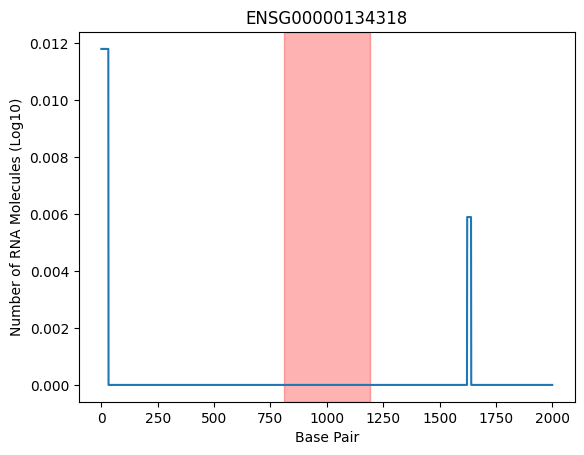

Pred: 2.148365
Actual: 2.1484823

K562: 


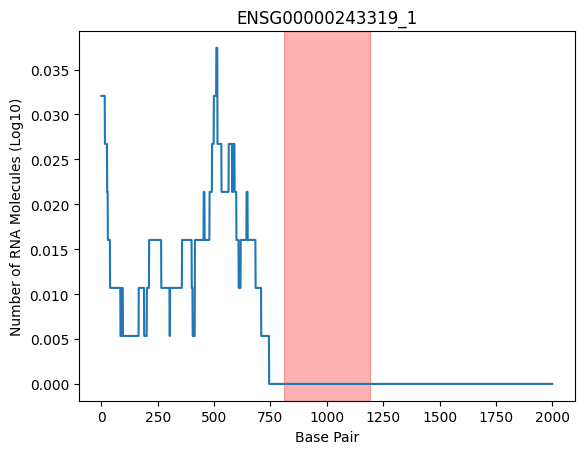

Pred: 1.2119815
Actual: 1.2118678


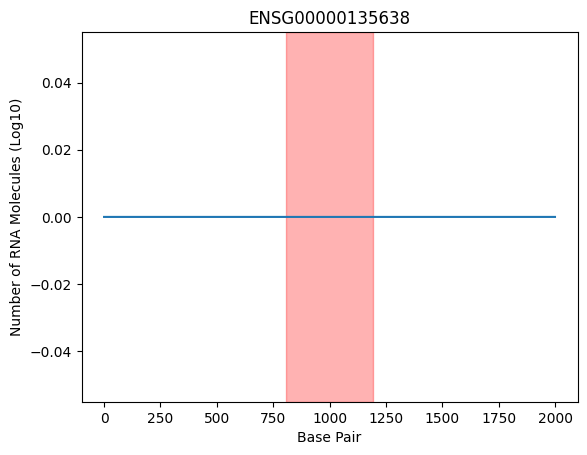

Pred: 1.8934821
Actual: 1.8934288


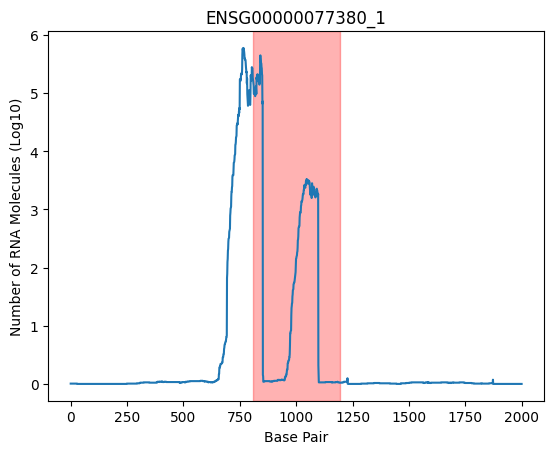

Pred: 2.5444367
Actual: 2.5443993


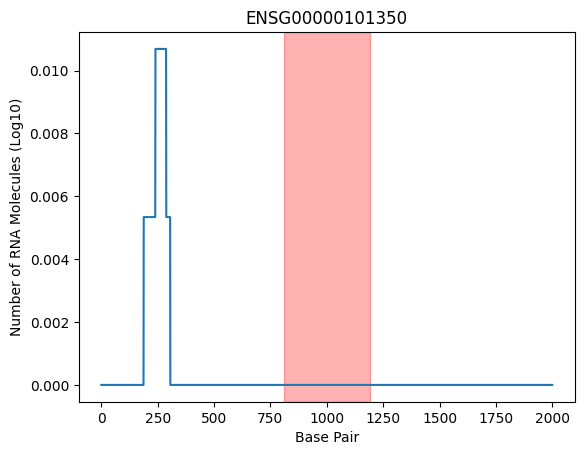

Pred: 1.942226
Actual: 1.941427


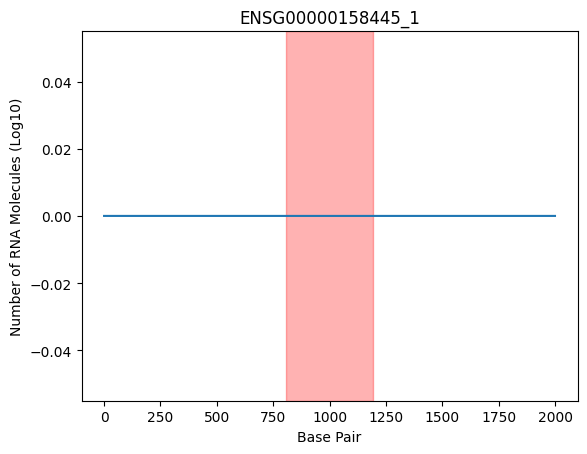

Pred: 1.6994836
Actual: 1.69897


In [27]:
# Individual Plots
signal_5_best_under_gm = gm_h5["rna"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
signal_5_best_under_k5 = k5_h5["rna"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

# signal_5_best_under_gm = 10 ** signal_5_best_under_gm - 1
# signal_5_best_under_k5 = 10 ** signal_5_best_under_k5 - 1

ensid_5_best_under_gm = gm_h5["ensid"][:][[gene.decode() in list(under_df_5_best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]]
ensid_5_best_under_k5 = k5_h5["ensid"][:][[gene.decode() in list(under_df_5_best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]]

print("GM12878: ")
for i, v in enumerate(ensid_5_best_under_gm):
    # plt.figure(figsize=(15, 15))
    # plt.xticks(fontsize=20)
    # plt.yticks(fontsize=20)

    plt.plot(signal_5_best_under_gm[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-23-25/underestimates/best/GM12878.{v.decode()}.png")
    plt.show()

    # print(v.decode())
    print(f"Pred: {gm["Pred"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {gm["actual"].iloc[gm[gm["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

print("\nK562: ")
for i, v in enumerate(ensid_5_best_under_k5):
    plt.plot(signal_5_best_under_k5[i])
    plt.xlabel("Base Pair")
    plt.ylabel("Number of RNA Molecules (Log10)")
    plt.title(v.decode())
    plt.axvspan(808, 1192, color="red", alpha=0.3)
    plt.savefig(f"predictions/2025-07-23-25/underestimates/best/K562.{v.decode()}.png")
    plt.show()

    print(f"Pred: {k5["Pred"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")
    print(f"Actual: {k5["actual"].iloc[k5[k5["Unnamed: 0"] == v.decode()]["Error"].idxmin()]}")

Zero Signal (Actual)

GM12878: 
Threshold: 0
Genes per Fold: 
1: 981
2: 822
3: 710
4: 617
5: 783
6: 649
7: 652
8: 815
9: 805
10: 909
11: 618
12: 719
Total Number of Matches: 9080
Total Matches with >= 1 Non-Zero Value: 4129
Percentage of TSSs with No Signal: 54.53%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000198744', 'ENSG00000225880', 'ENSG00000228794_2', 'ENSG00000187961', 'ENSG00000291156', 'ENSG00000237330', 'ENSG00000162571', 'ENSG00000169972', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000107404', 'ENSG00000162576', 'ENSG00000221978', 'ENSG00000224870', 'ENSG00000242485', 'ENSG00000235098', 'ENSG00000205116', 'ENSG00000179403', 'ENSG00000215915', 'ENSG00000160072', 'ENSG00000160075_1', 'ENSG00000228594', 'ENSG00000272106', 'ENSG00000197530_1', 'ENSG00000197530_2', 'ENSG00000189409', 'ENSG00000248333', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000187730', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG00000197921', 'ENSG00000157873_1', 'ENSG00000157873_2', 'ENSG00000238164', 'ENSG00000130762', 

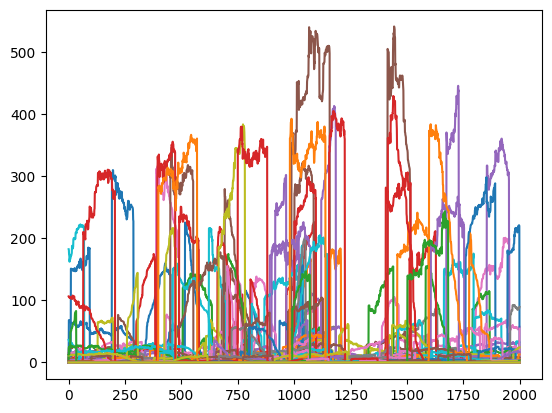

K562: 
Threshold: 0
Genes per Fold: 
1: 1253
2: 1155
3: 928
4: 772
5: 1085
6: 846
7: 862
8: 1108
9: 1116
10: 1237
11: 843
12: 1040
Total Number of Matches: 12245
Total Matches with >= 1 Non-Zero Value: 6246
Percentage of TSSs with No Signal: 48.99%
Genes w/ Signal: ['ENSG00000310526', 'ENSG00000225630', 'ENSG00000237973', 'ENSG00000229344', 'ENSG00000240409', 'ENSG00000228794', 'ENSG00000228794_1', 'ENSG00000223764', 'ENSG00000187634_1', 'ENSG00000187961', 'ENSG00000188157', 'ENSG00000131591', 'ENSG00000186891', 'ENSG00000186827', 'ENSG00000078808', 'ENSG00000176022', 'ENSG00000224051', 'ENSG00000224051_1', 'ENSG00000169962', 'ENSG00000175756', 'ENSG00000179403', 'ENSG00000197785', 'ENSG00000160075', 'ENSG00000160075_1', 'ENSG00000197530', 'ENSG00000272106', 'ENSG00000078369', 'ENSG00000078369_1', 'ENSG00000169885', 'ENSG00000178821', 'ENSG00000142609', 'ENSG00000142609_1', 'ENSG00000187730', 'ENSG00000067606_1', 'ENSG00000067606_2', 'ENSG00000067606_3', 'ENSG00000162585', 'ENSG0000015

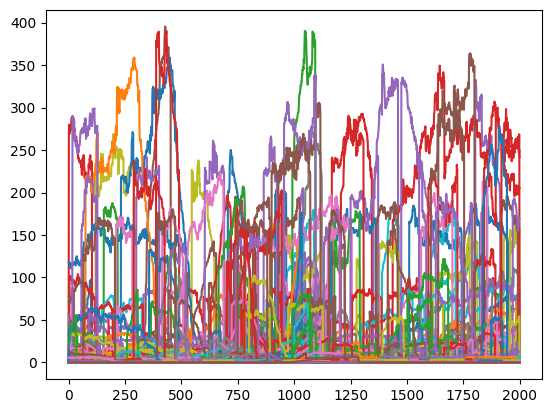

In [28]:
print("GM12878: ")
gm_no_signal_actual = test_thresholds(gm, gm_h5, "actual", [0], "eq", "predictions/2025-07-23-25/zero", "GM12878")

print("K562: ")
k5_no_signal_actual = test_thresholds(k5, k5_h5, "actual", [0], "eq", "predictions/2025-07-23-25/zero", "K562")

Aggregate FP, FN, TP, TN

In [29]:
# GM12878
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    preds = [actuals[idx] if gm["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in gm["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": gm["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "Pred": [gm["actual"].iloc[idx] > best_threshold if gm["Error"].iloc[idx] < 1.5 else 1 - (gm["actual"].iloc[idx] > best_threshold) for idx, pred in gm["Pred"].items()],
    "fold_idx": gm["fold_idx"]
}
gm_binary = pd.DataFrame(pred_actual) 

# K562
best_score = 0
best_threshold = 0
for threshold in np.linspace(0, 5, 100):
    # preds = [1 if pred > threshold else 0 for pred in gm["Pred"]]
    # actuals = [1 if actual > threshold else 0 for actual in gm["actual"]]
    actuals = [1 if actual > threshold else 0 for actual in k5["actual"]]
    preds = [actuals[idx] if k5["Error"].iloc[idx] < 1.5 else 1 - actuals[idx] for idx, pred in k5["Pred"].items()]
    score = f1_score(actuals, preds)
    if score > best_score:
        best_score = score
        best_threshold = threshold
print(f"Best Threshold: {best_threshold} w/ {best_score} F1 Score")
pred_actual = {
    "ENSID": k5["Unnamed: 0"],
    # "Pred" : [1 if pred > best_threshold else 0 for pred in gm["Pred"]],
    # "actual" : [1 if actual > best_threshold else 0 for actual in gm["actual"]],
    "actual" : [1 if actual > best_threshold else 0 for actual in k5["actual"]],
    "Pred": [k5["actual"].iloc[idx] > best_threshold if k5["Error"].iloc[idx] < 1.5 else 1 - (k5["actual"].iloc[idx] > best_threshold) for idx, pred in k5["Pred"].items()],
    "fold_idx": k5["fold_idx"]
}
k5_binary = pd.DataFrame(pred_actual) 


Best Threshold: 0.0 w/ 0.9680510363557172 F1 Score
Best Threshold: 0.0 w/ 0.9494271636286691 F1 Score


In [30]:
# GM12878
fp_gm = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 0)]
fn_gm = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 1)]
tp_gm = gm_binary[(gm_binary["Pred"] == 1) & (gm_binary["actual"] == 1)]
tn_gm = gm_binary[(gm_binary["Pred"] == 0) & (gm_binary["actual"] == 0)]

In [31]:
# GM12878
a = [fp_gm, fn_gm, tp_gm, tn_gm]
for b in a:
    print(len(b))

862
385
18892
8218


In [32]:
# GM12878
dfs = {"False Positive": fp_gm, 
       "False Negative": fn_gm, 
       "True Positive": tp_gm, 
       "True Negative": tn_gm}
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in gm_h5["ensid"]]
    rna = gm_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
    plt.savefig(f"predictions/2025-07-23-25/aggregate_confusion/gm_{title}.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [33]:
# K562
fp_k5 = k5_binary[(k5_binary["Pred"] == 1) & (k5_binary["actual"] == 0)]
fn_k5 = k5_binary[(k5_binary["Pred"] == 0) & (k5_binary["actual"] == 1)]
tp_k5 = k5_binary[(k5_binary["Pred"] == 1) & (k5_binary["actual"] == 1)]
tn_k5 = k5_binary[(k5_binary["Pred"] == 0) & (k5_binary["actual"] == 0)]

In [34]:
# K562
a = [fp_k5, fn_k5, tp_k5, tn_k5]
for b in a:
    print(len(b))

1265
408
15704
10980


In [35]:
# K562
dfs = {"False Positive": fp_k5, 
       "False Negative": fn_k5, 
       "True Positive": tp_k5, 
       "True Negative": tn_k5}
for title, df in dfs.items():
    bool_df = [gene.decode() in list(df["ENSID"]) for gene in k5_h5["ensid"]]
    rna = k5_h5["rna"][:][bool_df]
    plt.plot(np.mean(rna, axis=0))
    plt.xlabel("Base Pairs")
    plt.ylabel("RNA Signal")
    plt.title(title)
#     plt.show()
    plt.savefig(f"predictions/2025-07-23-25/aggregate_confusion/k5_{title}.png")
    plt.clf()



<Figure size 640x480 with 0 Axes>

Find genes with strong peaks in false positives

Threshold: 0.0
Number of Genes w/ Strong Peaks: 430


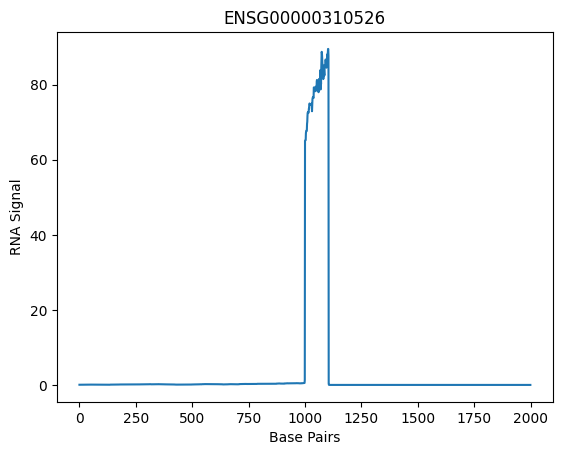

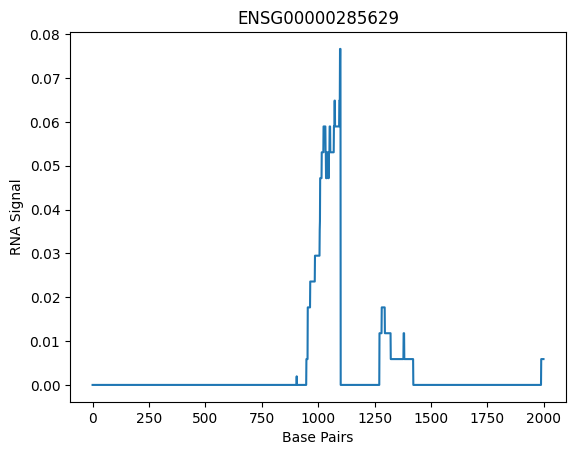

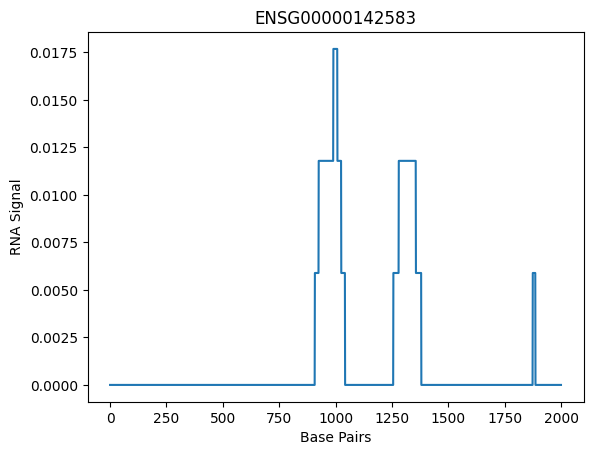

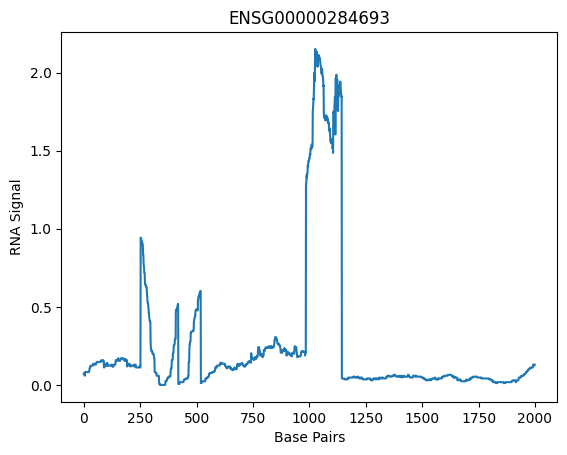

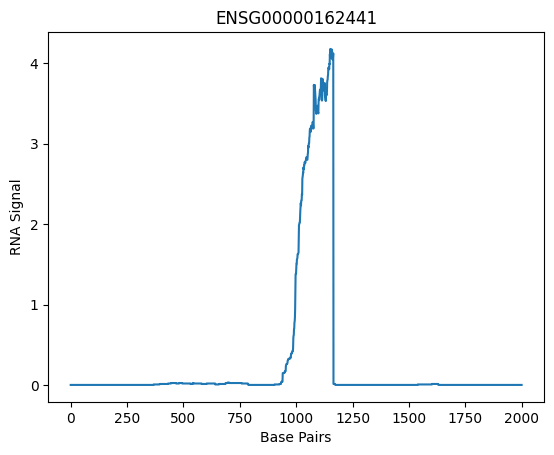

Threshold: 0.5
Number of Genes w/ Strong Peaks: 269


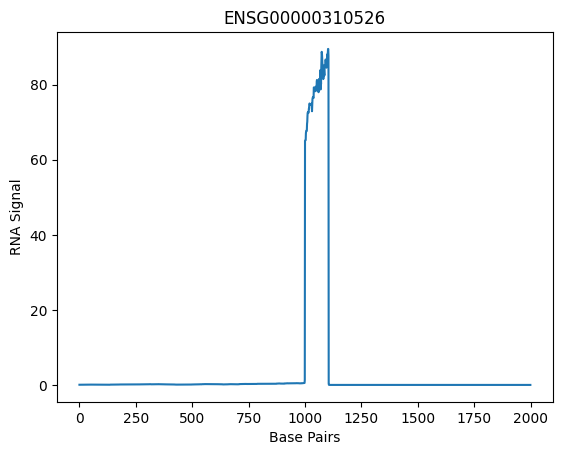

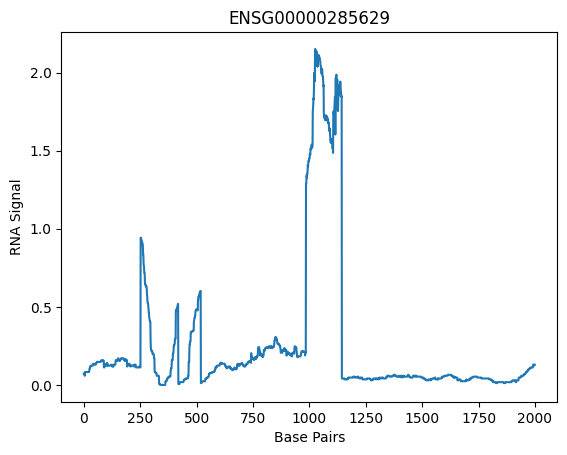

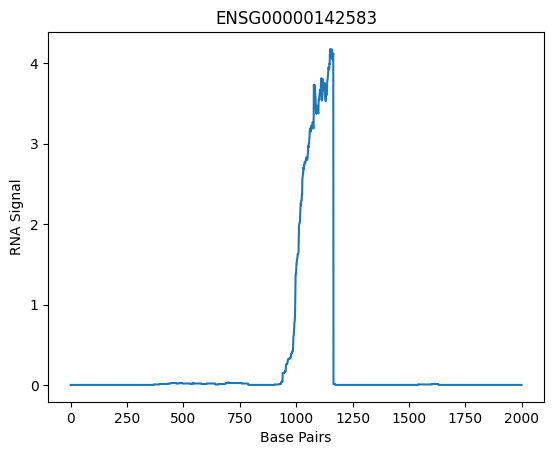

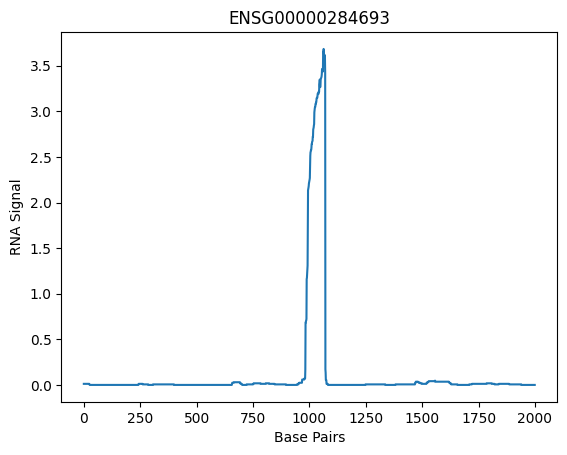

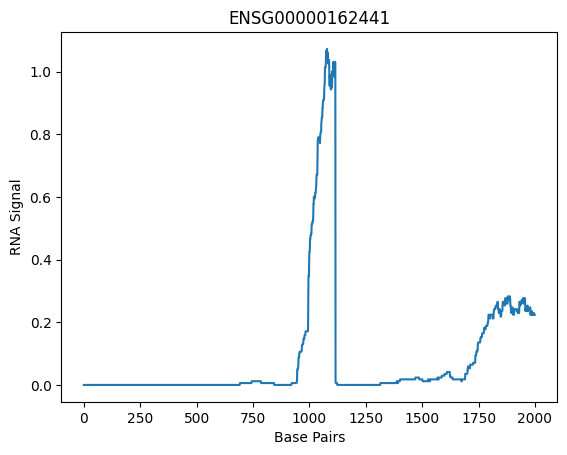

Threshold: 1.0
Number of Genes w/ Strong Peaks: 217


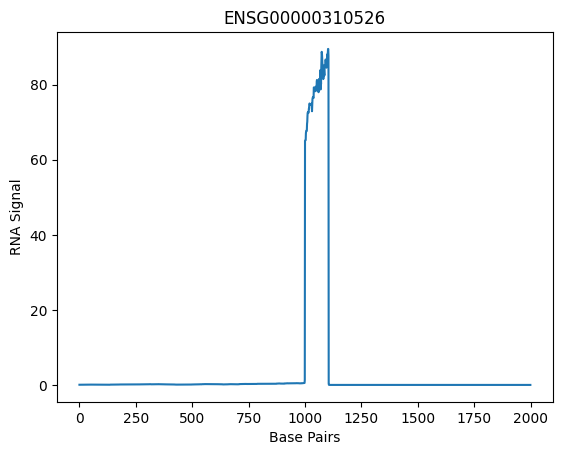

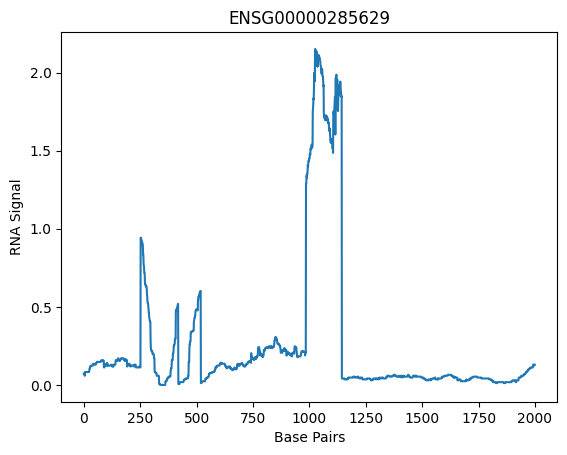

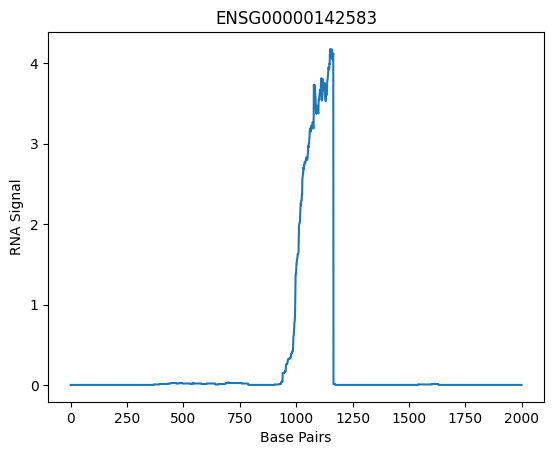

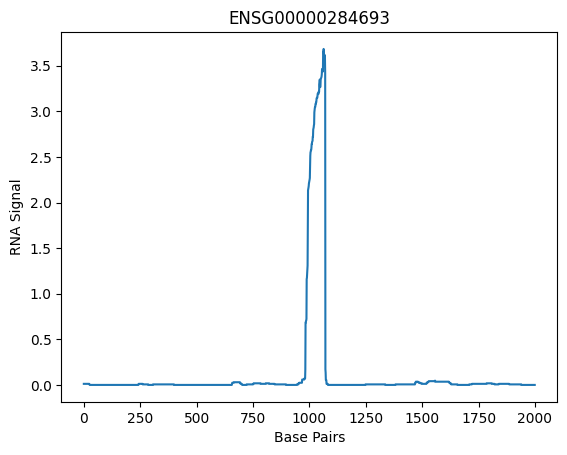

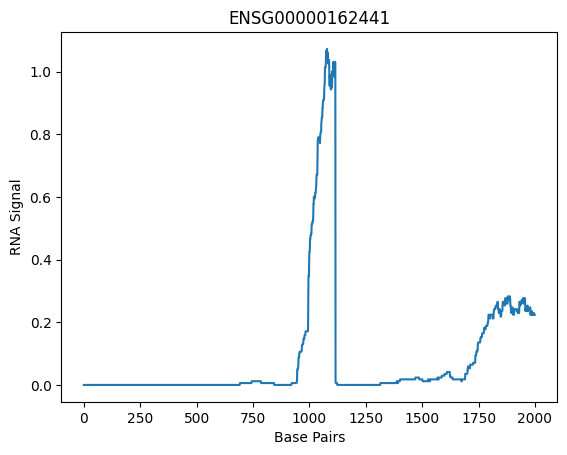

Threshold: 1.5
Number of Genes w/ Strong Peaks: 180


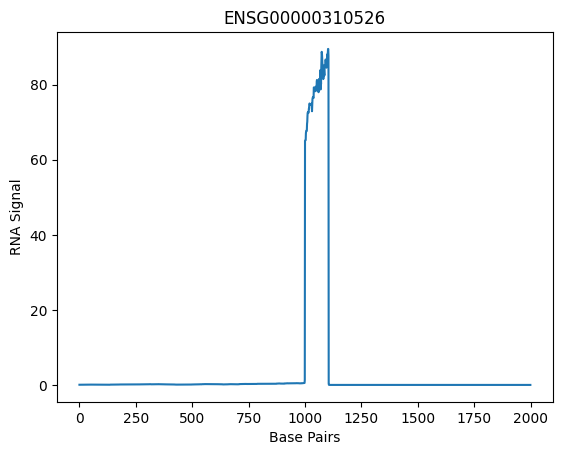

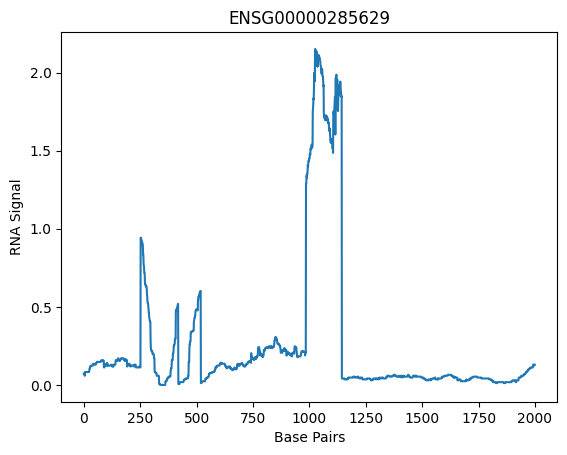

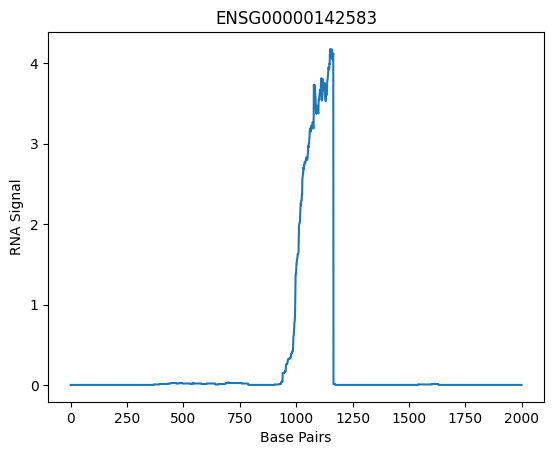

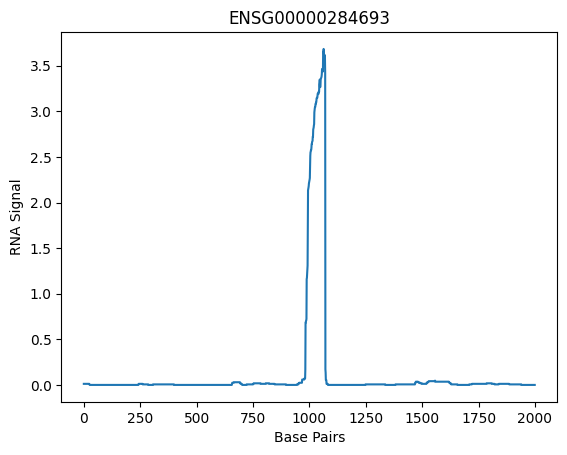

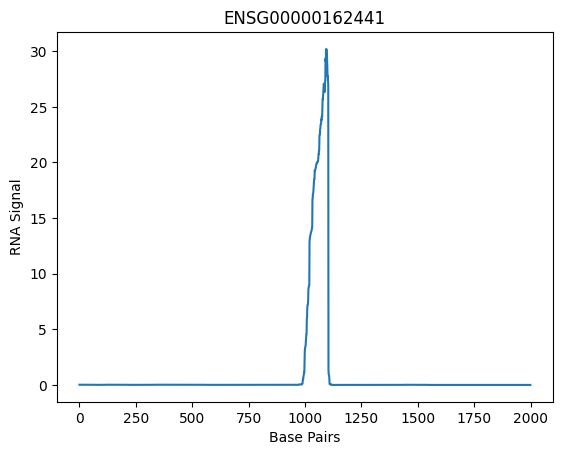

Threshold: 2.0
Number of Genes w/ Strong Peaks: 158


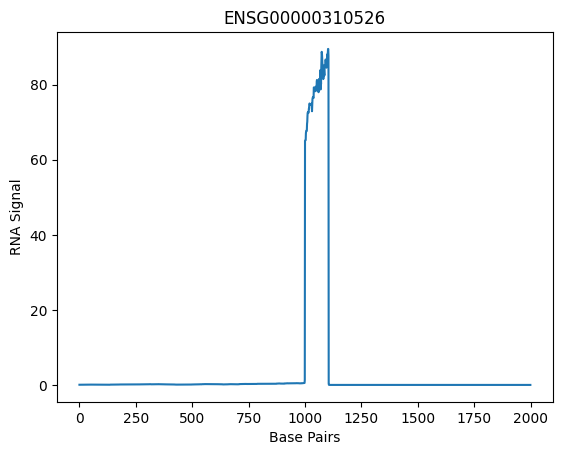

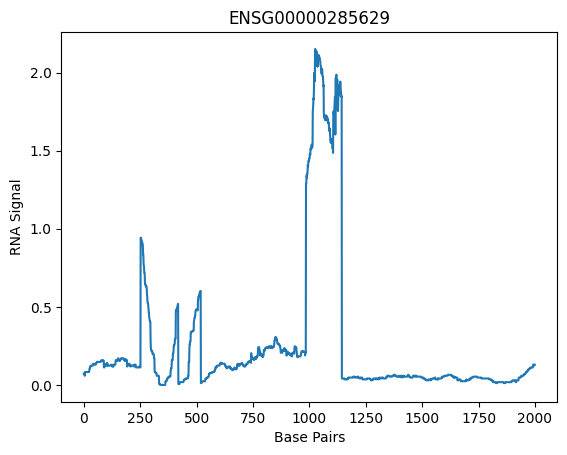

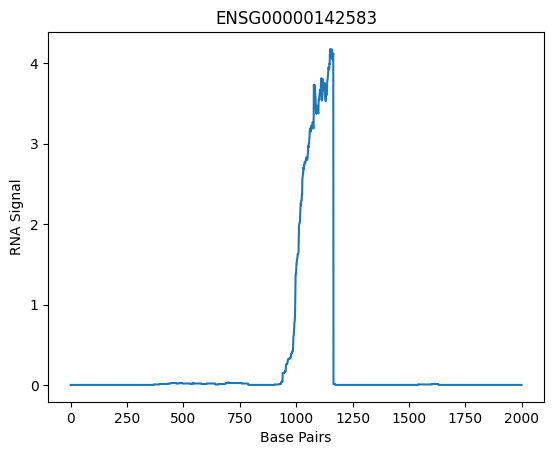

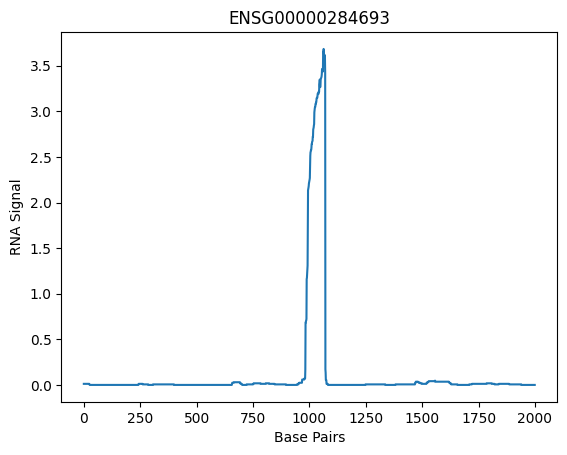

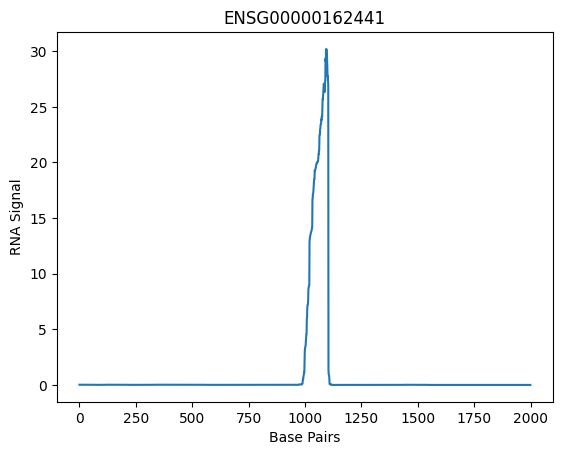

Threshold: 2.5
Number of Genes w/ Strong Peaks: 141


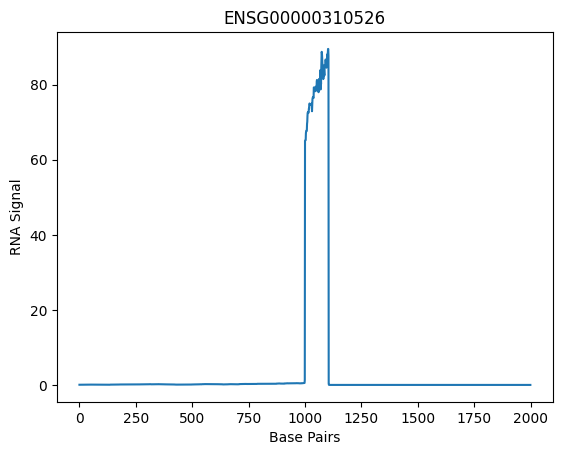

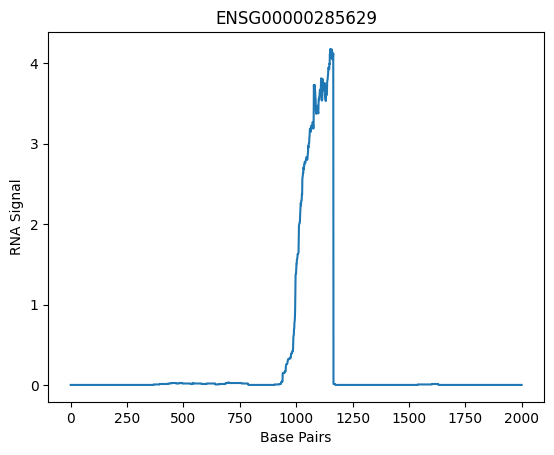

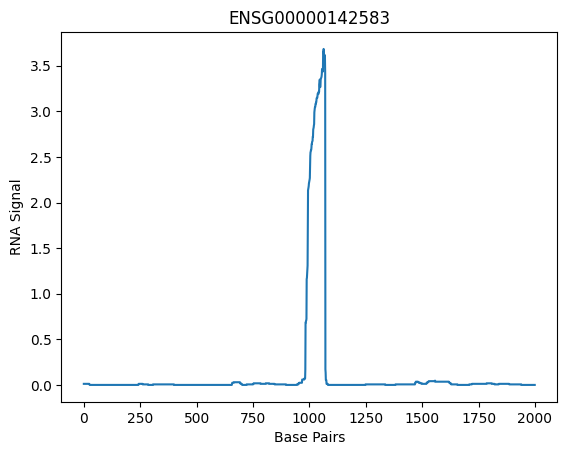

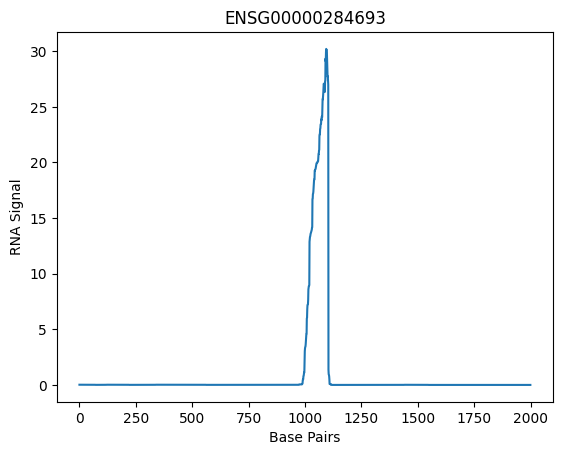

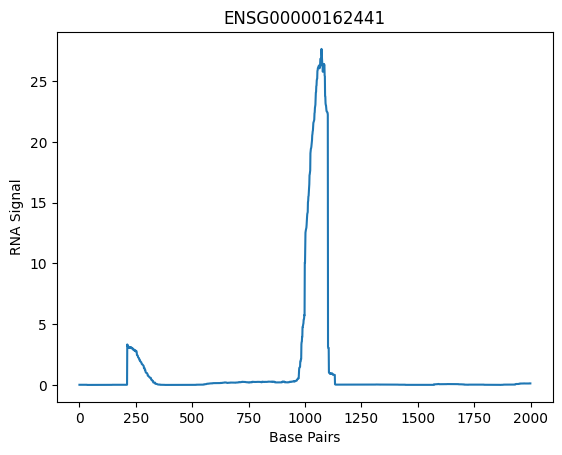

Threshold: 3.0
Number of Genes w/ Strong Peaks: 128


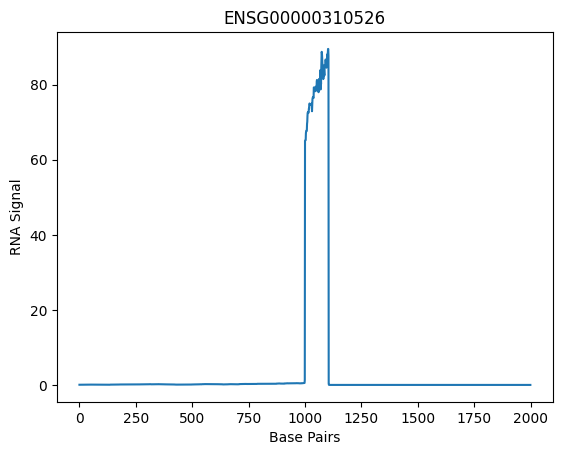

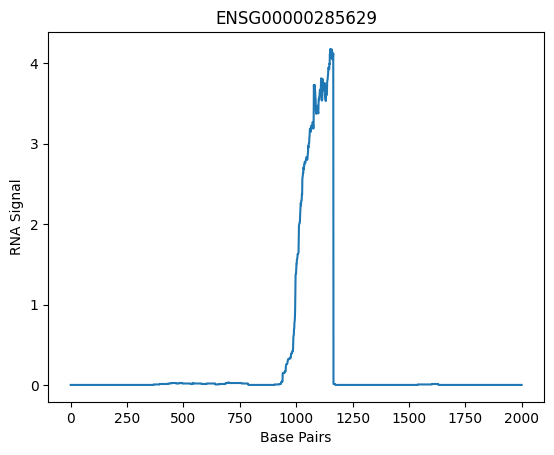

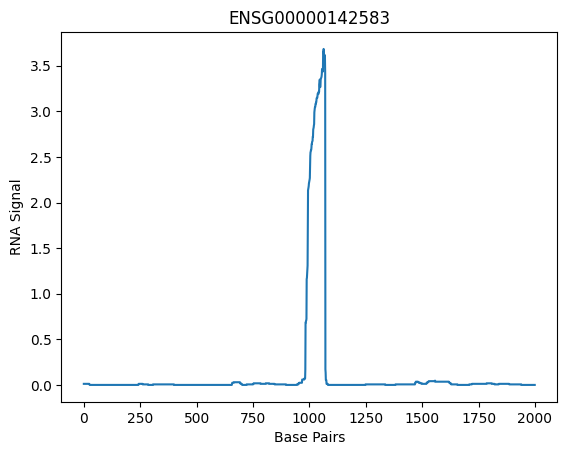

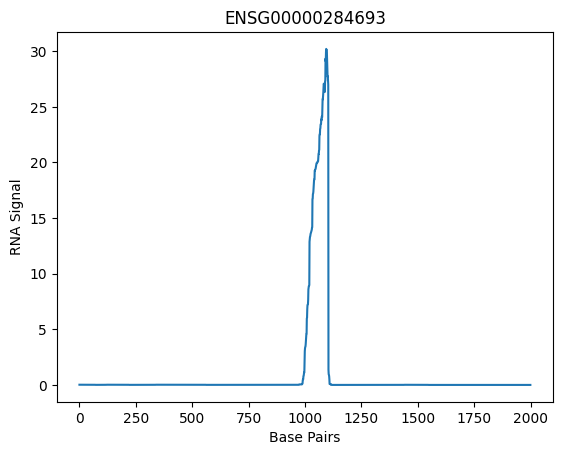

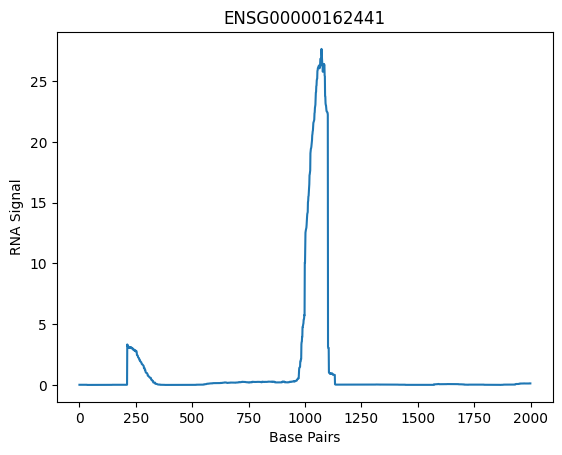

Threshold: 3.5
Number of Genes w/ Strong Peaks: 116


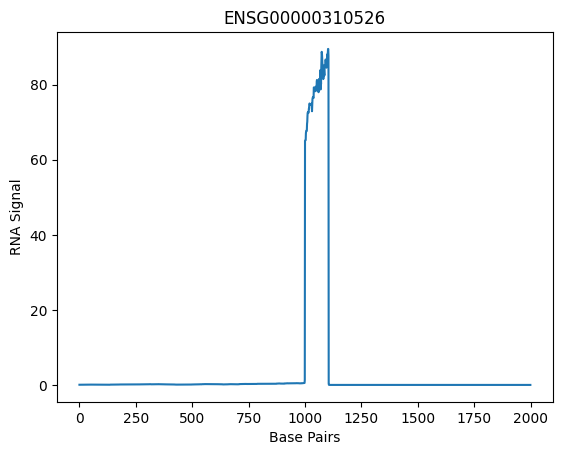

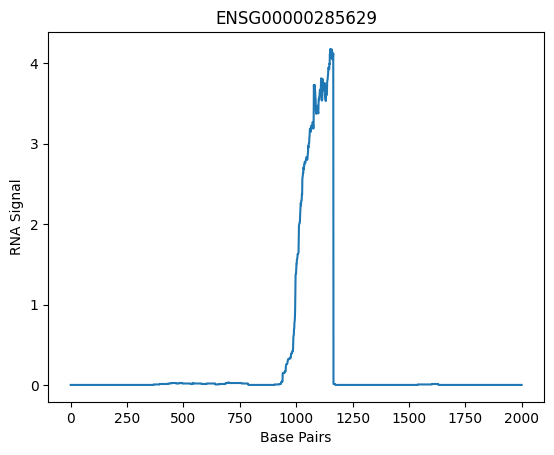

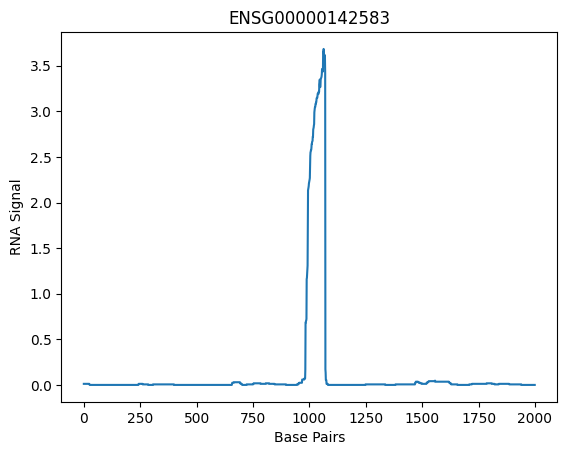

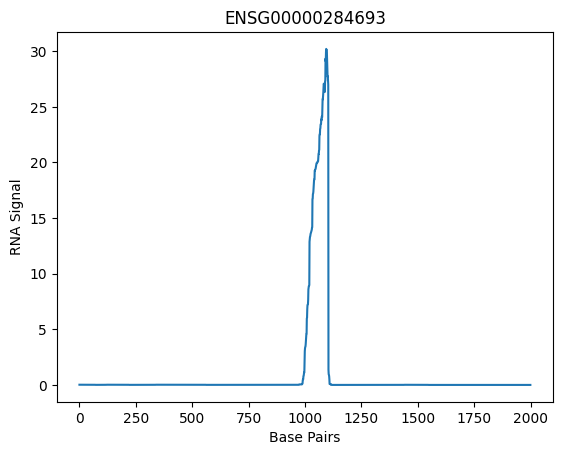

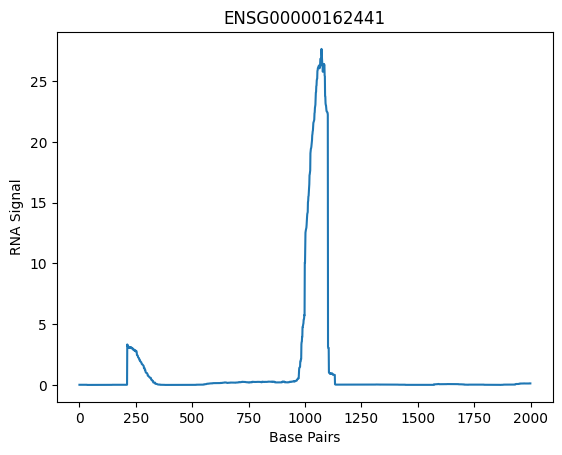

Threshold: 4.0
Number of Genes w/ Strong Peaks: 105


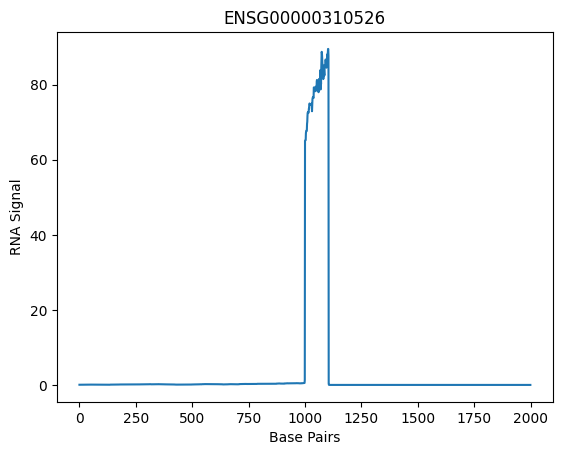

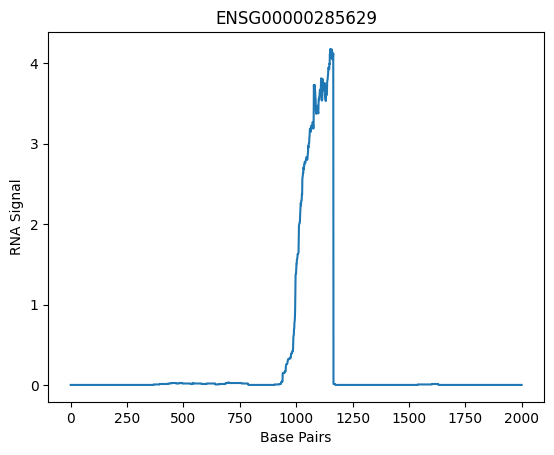

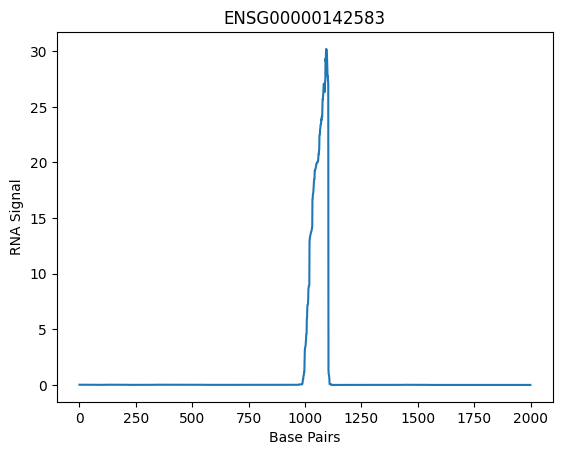

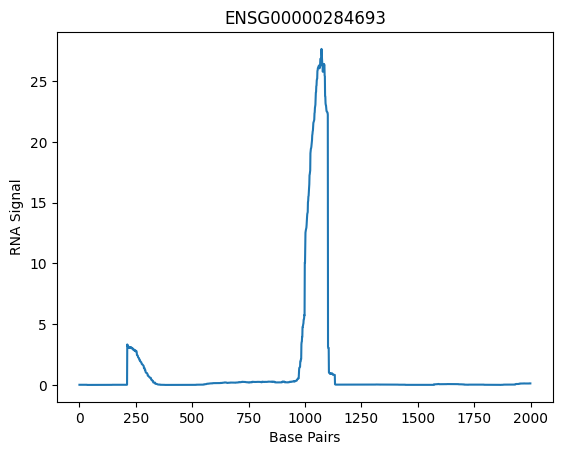

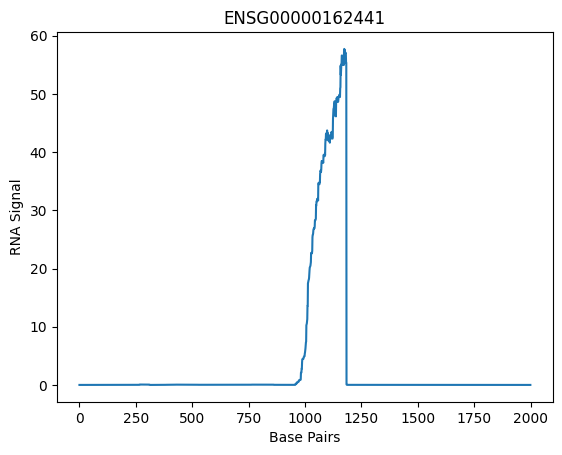

Threshold: 4.5
Number of Genes w/ Strong Peaks: 99


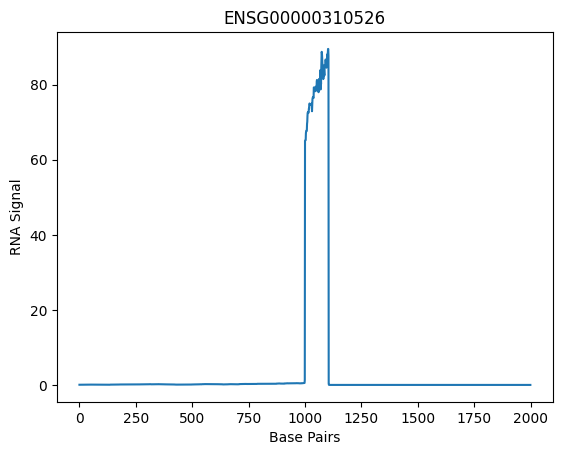

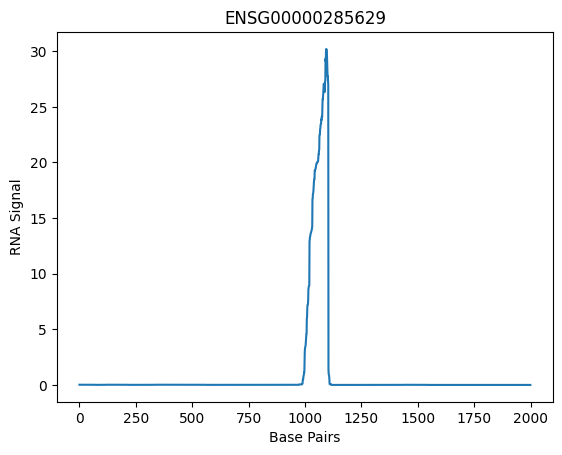

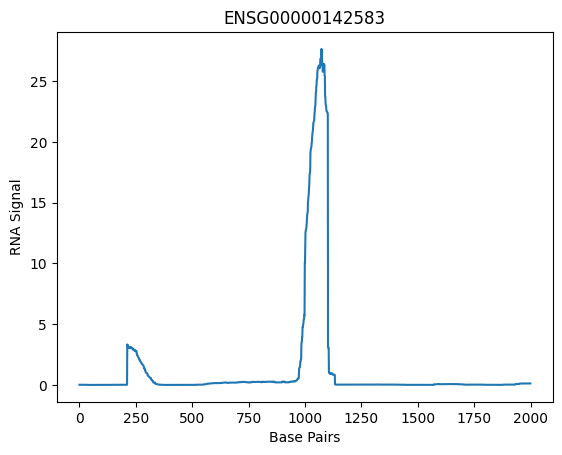

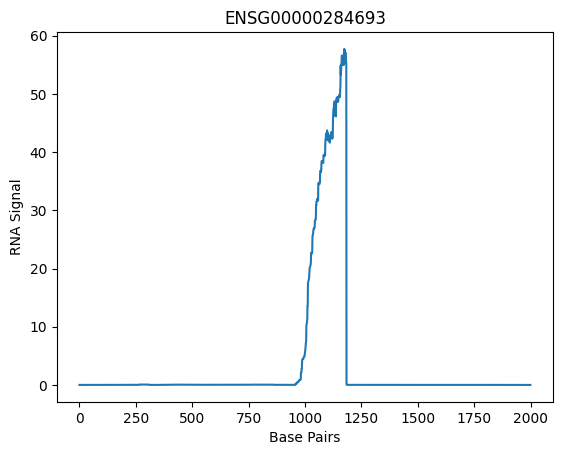

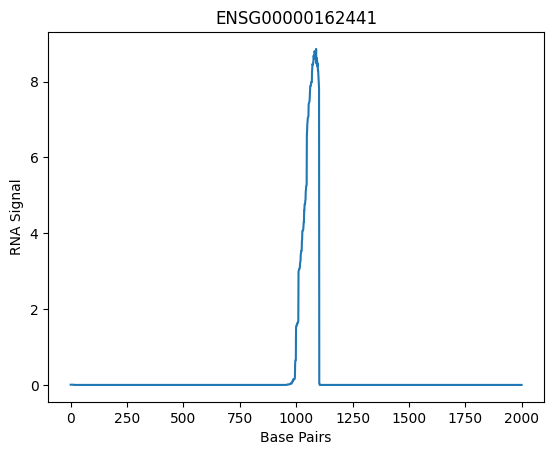

Threshold: 5.0
Number of Genes w/ Strong Peaks: 93


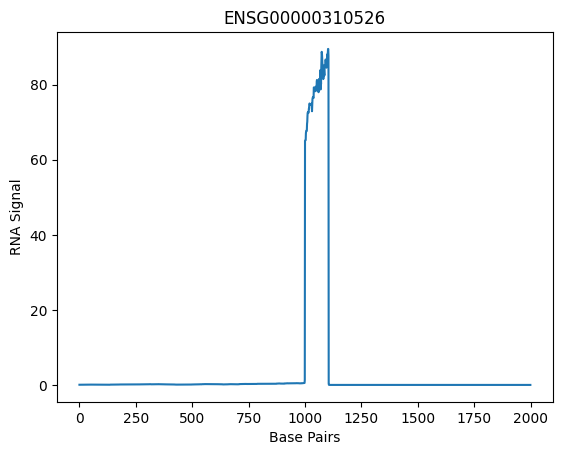

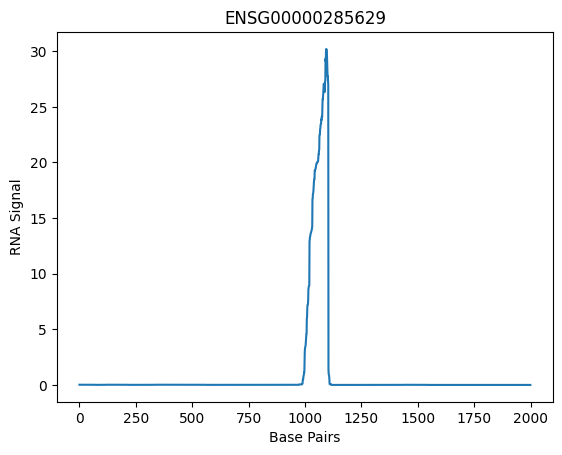

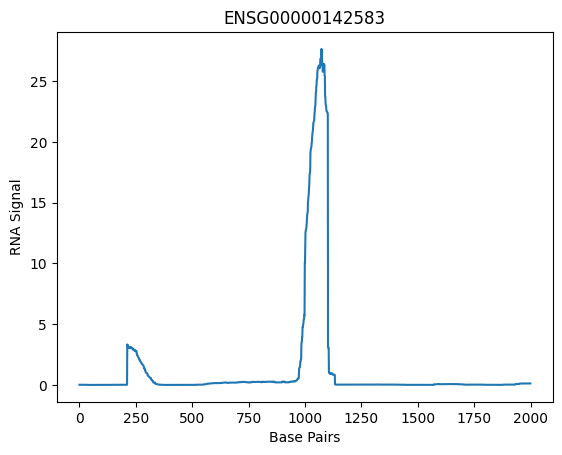

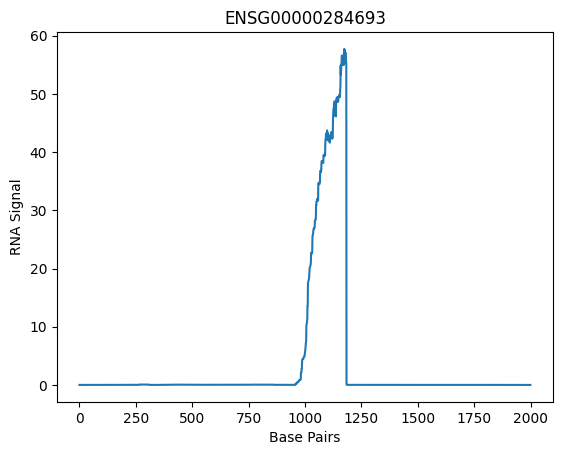

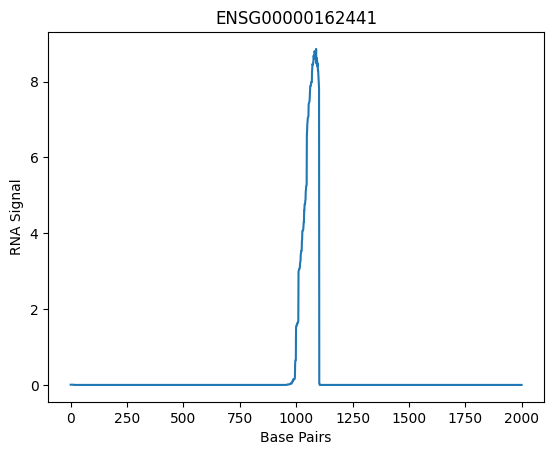

In [36]:
# GM12878
thresholds = np.linspace(0, 5, 11)
bool_df = [gene.decode() in list(fp_gm["ENSID"]) for gene in gm_h5["ensid"]]
rna = gm_h5["rna"][:][bool_df]
ensid = gm_h5["ensid"][:][bool_df]

peak_counts = []
for threshold in thresholds:
    peak = [ensid[idx].decode() for idx, sig in enumerate(rna) if np.max(sig) in sig[808:1192] and np.max(sig) > threshold]
    peak_bool = [gene.decode() in peak for gene in gm_h5["ensid"]]

    peak_counts.append(sum(peak_bool))
    print(f"Threshold: {threshold}\nNumber of Genes w/ Strong Peaks: {sum(peak_bool)}")
    for idx, gene in enumerate(gm_h5["rna"][:][peak_bool][0:5]):
        plt.title(ensid[idx].decode())
        plt.ylabel("RNA Signal")
        plt.xlabel("Base Pairs")
        plt.plot(gene)
        plt.show()

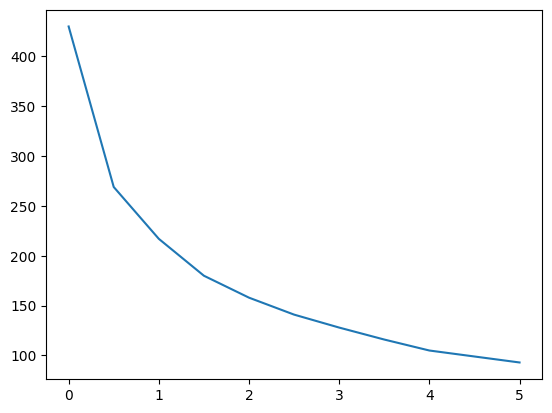

In [37]:
# GM12878
plt.plot(thresholds, peak_counts)

Threshold: 0.0
Number of Genes w/ Strong Peaks: 598


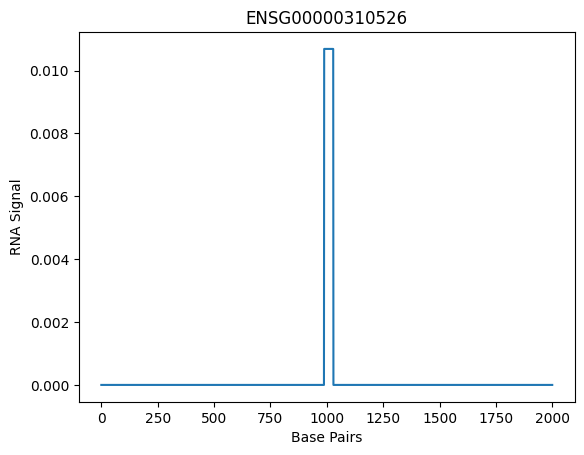

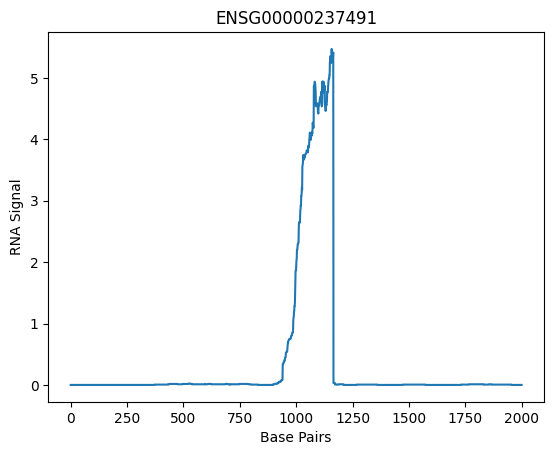

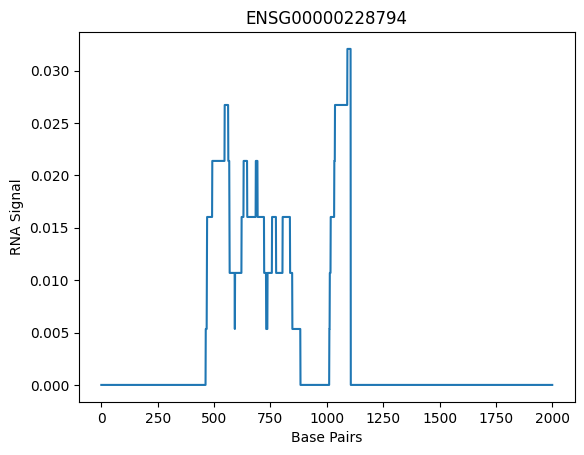

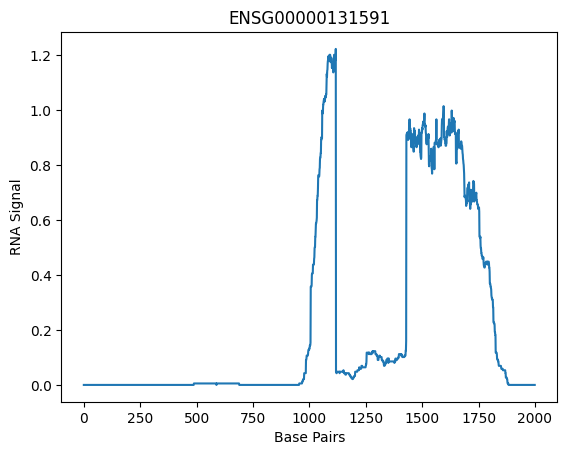

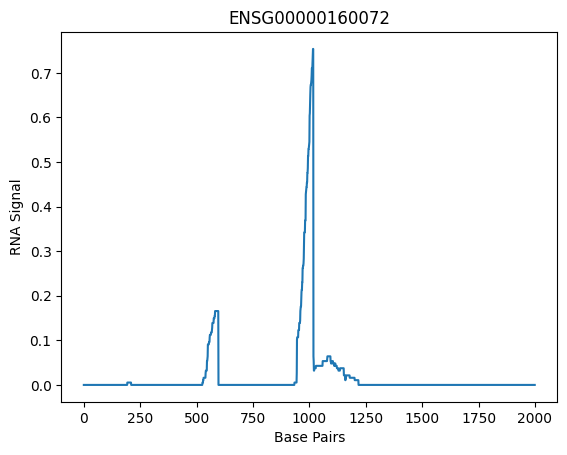

Threshold: 0.5
Number of Genes w/ Strong Peaks: 417


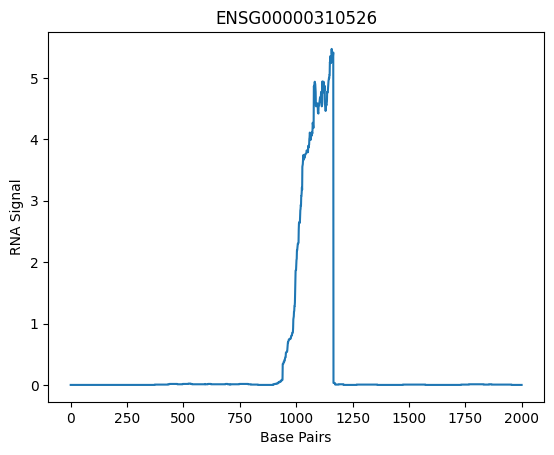

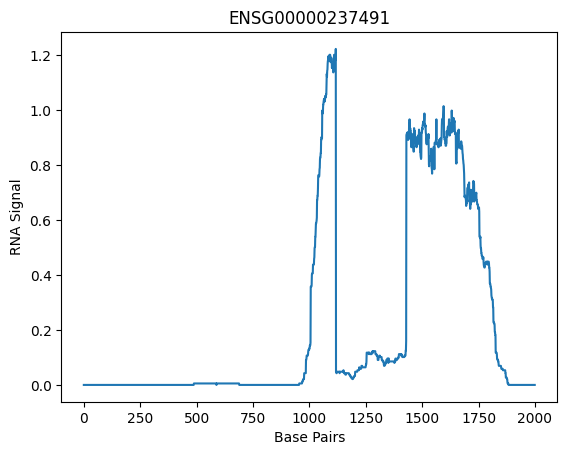

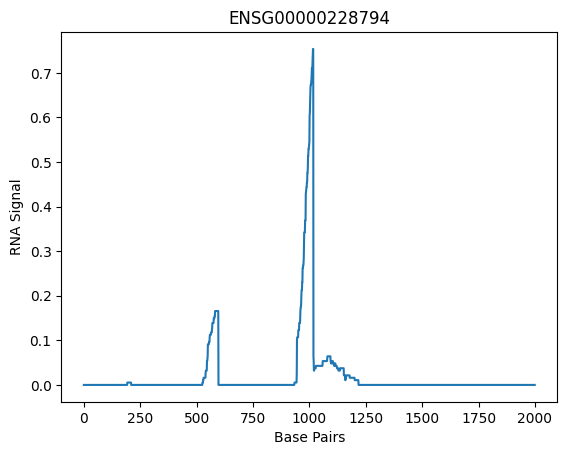

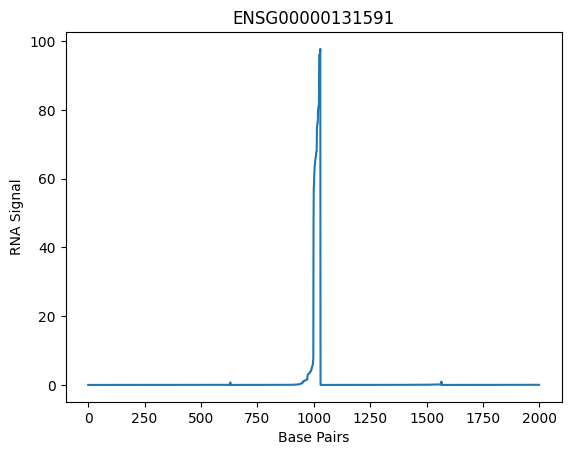

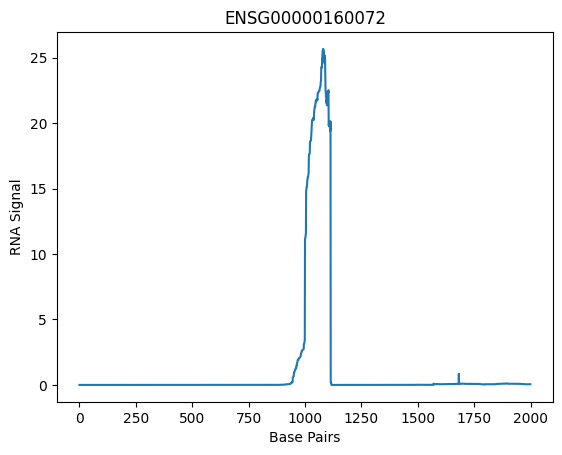

Threshold: 1.0
Number of Genes w/ Strong Peaks: 348


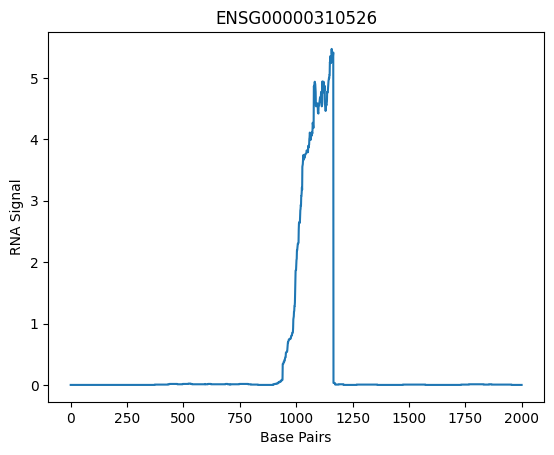

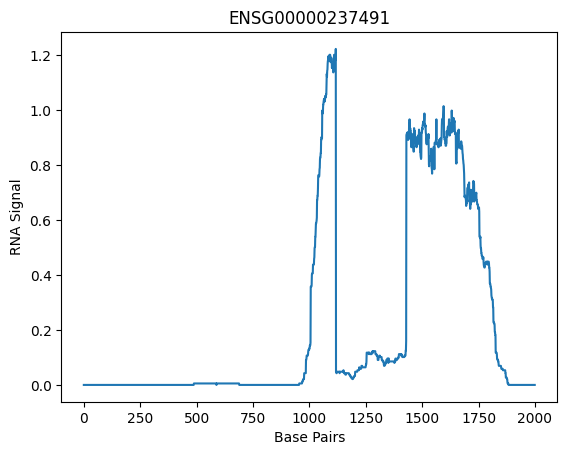

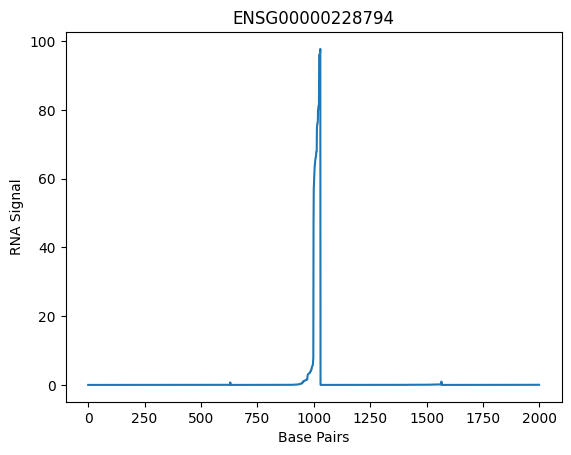

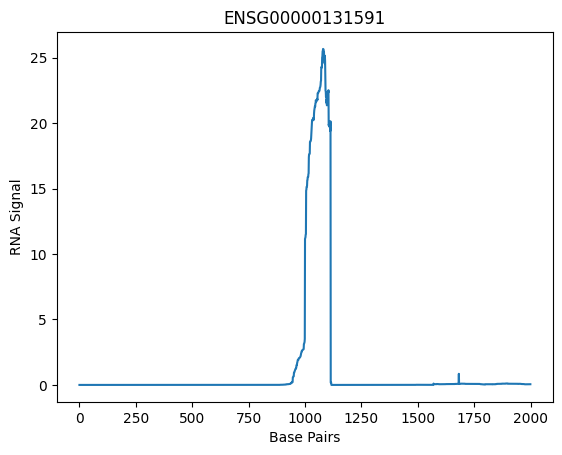

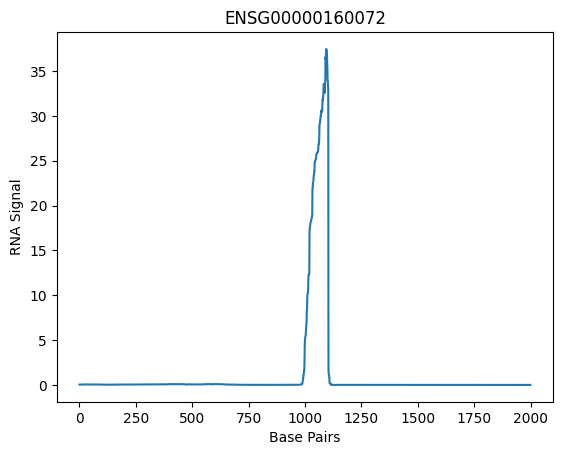

Threshold: 1.5
Number of Genes w/ Strong Peaks: 303


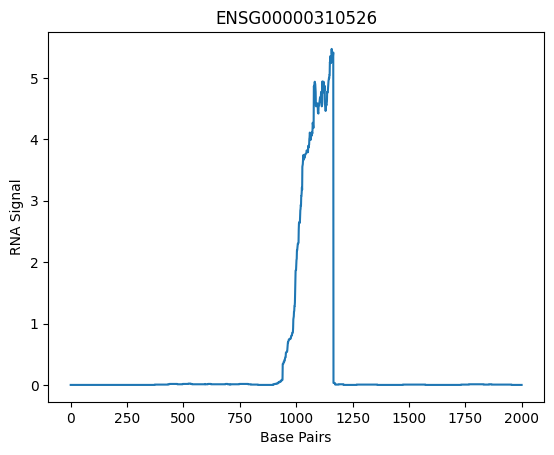

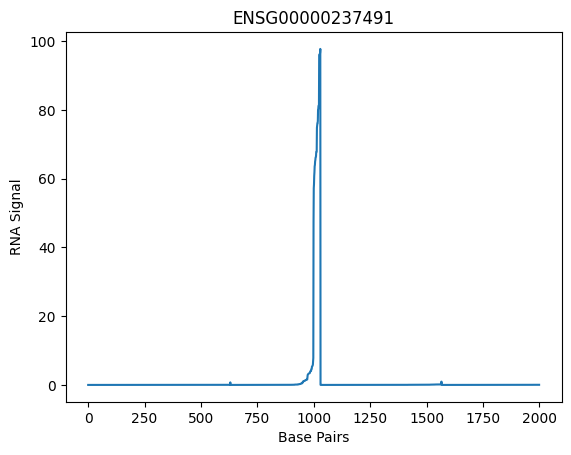

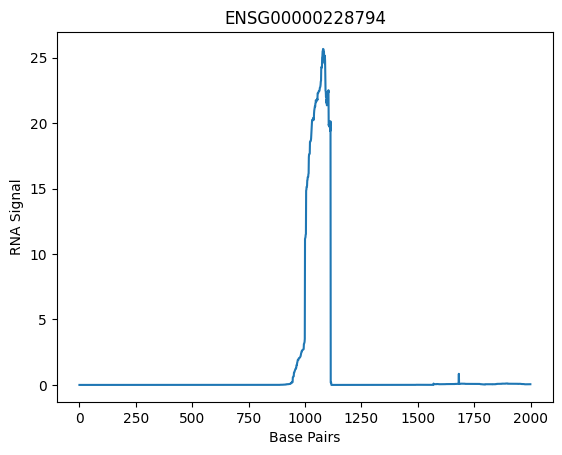

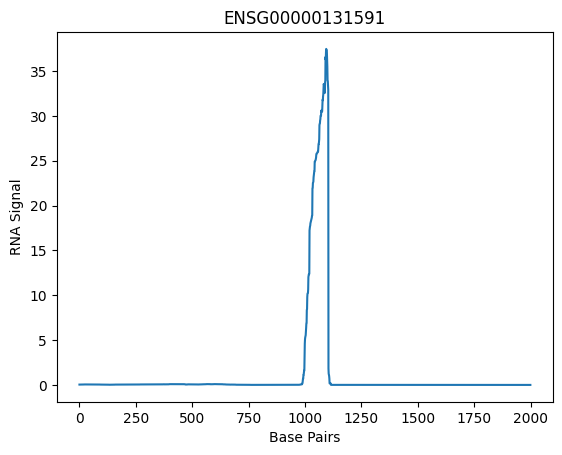

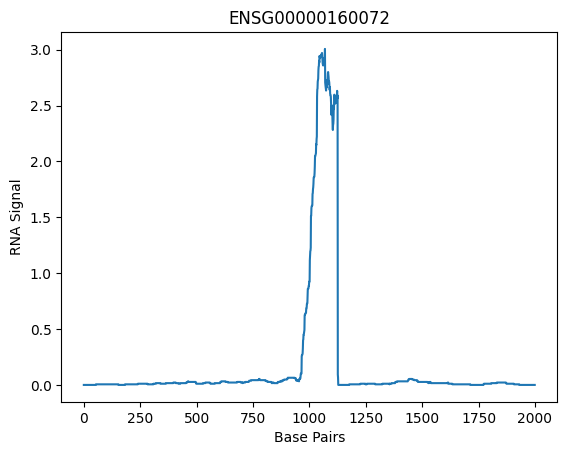

Threshold: 2.0
Number of Genes w/ Strong Peaks: 267


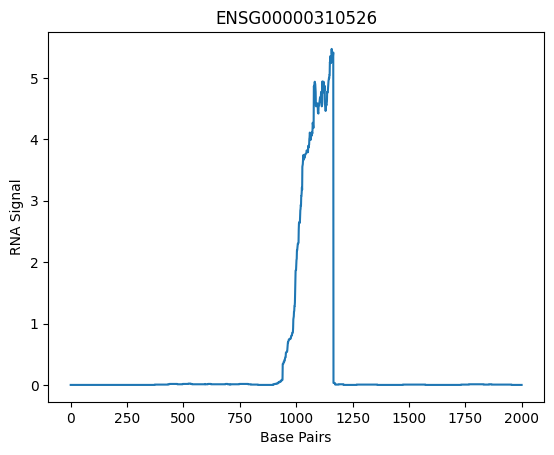

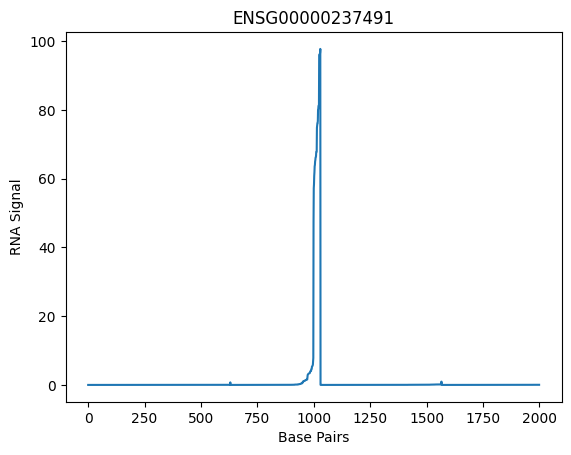

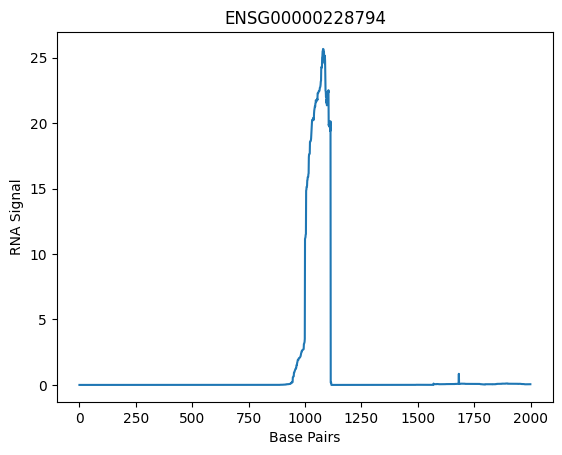

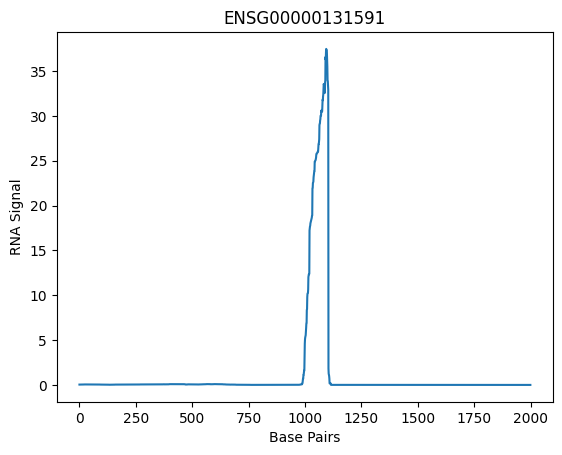

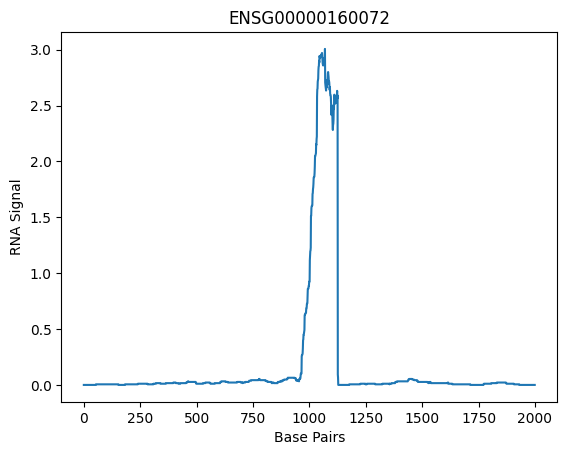

Threshold: 2.5
Number of Genes w/ Strong Peaks: 237


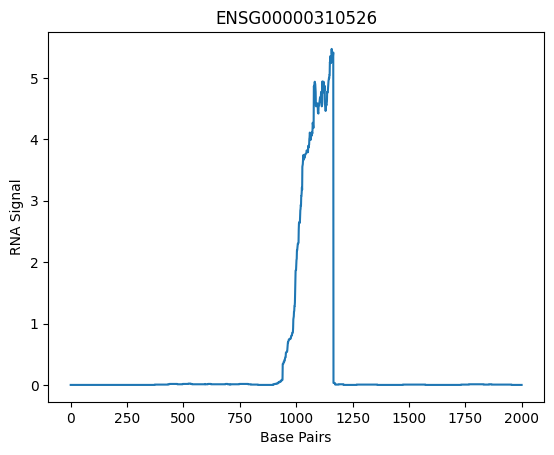

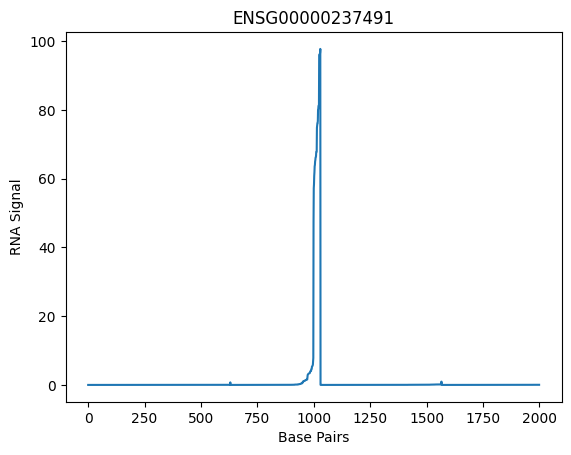

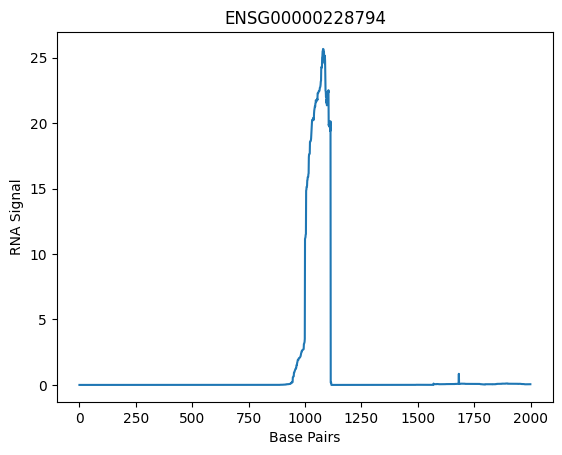

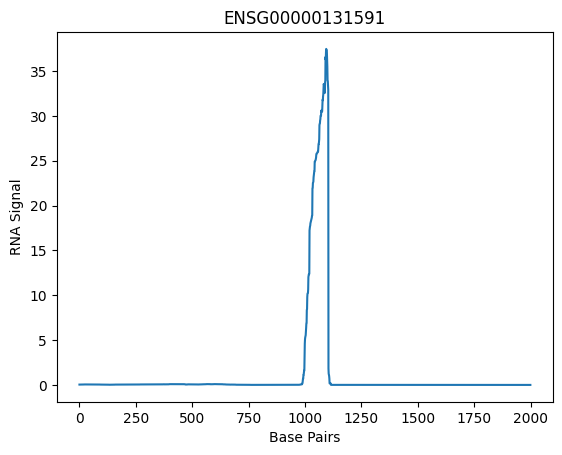

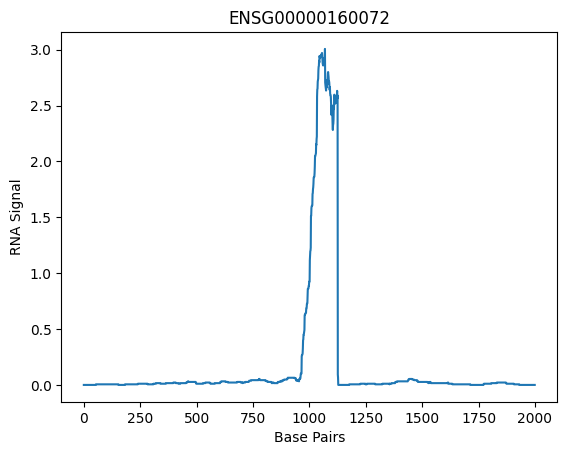

Threshold: 3.0
Number of Genes w/ Strong Peaks: 226


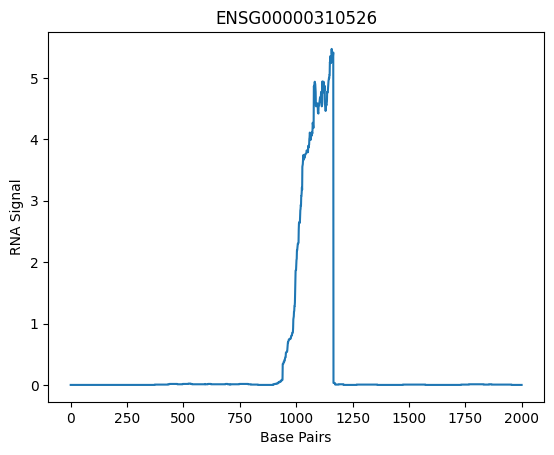

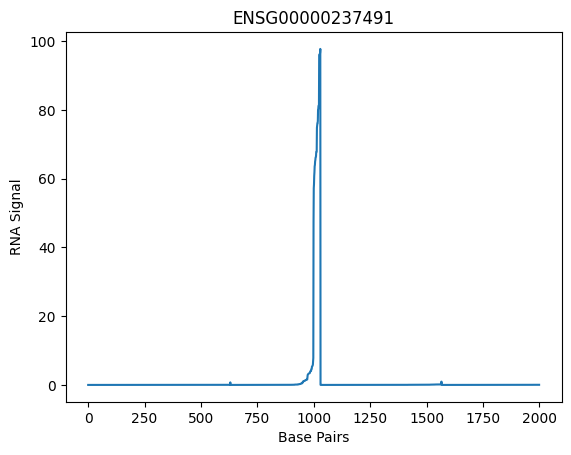

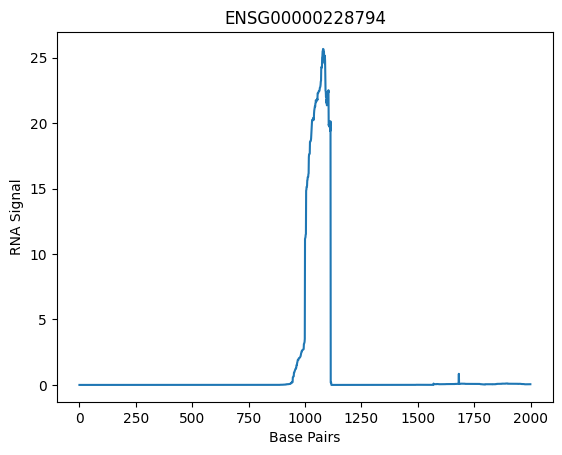

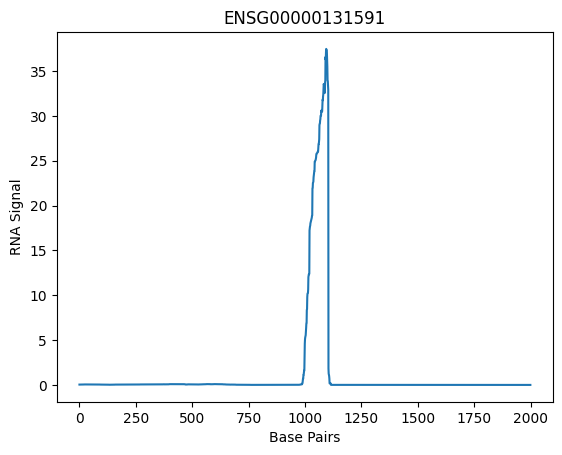

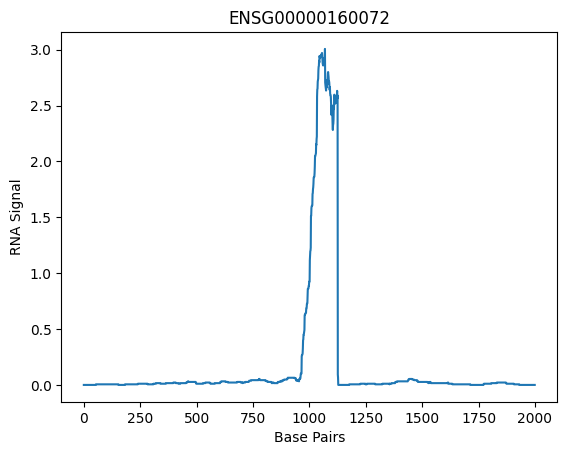

Threshold: 3.5
Number of Genes w/ Strong Peaks: 209


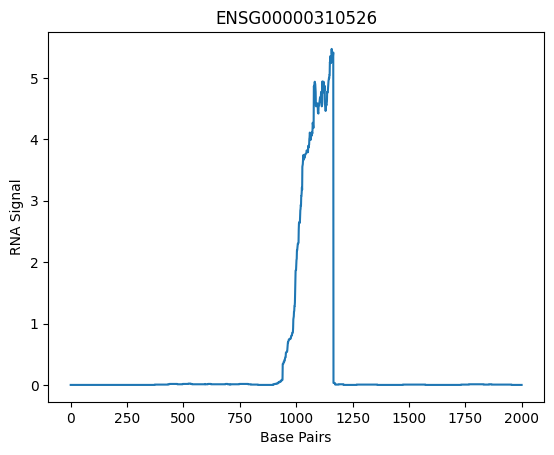

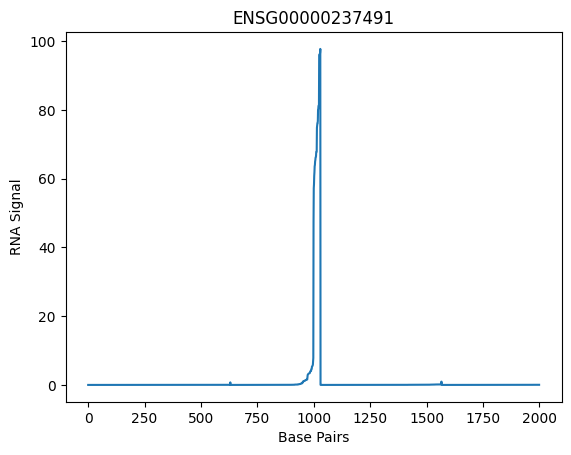

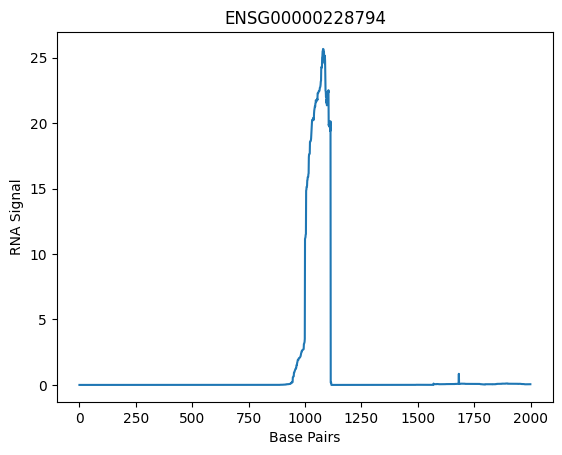

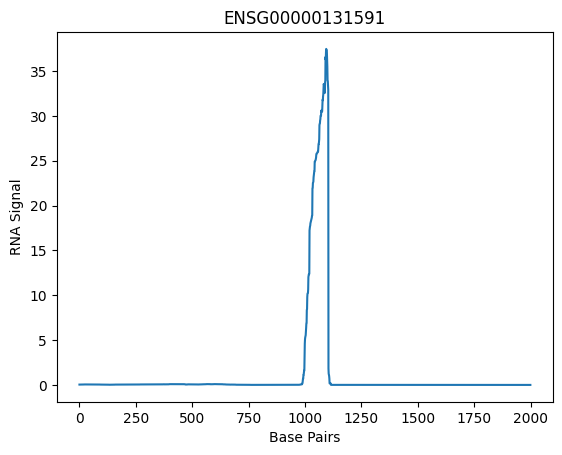

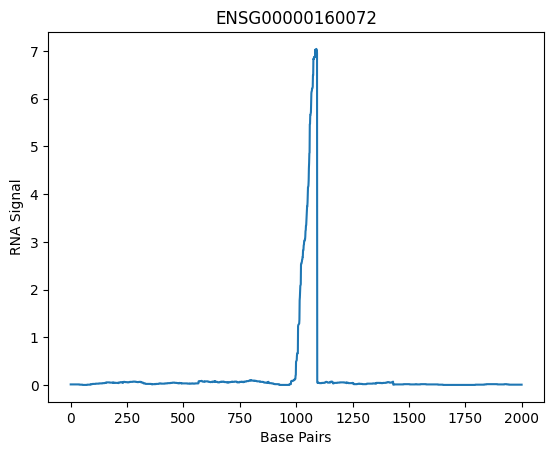

Threshold: 4.0
Number of Genes w/ Strong Peaks: 199


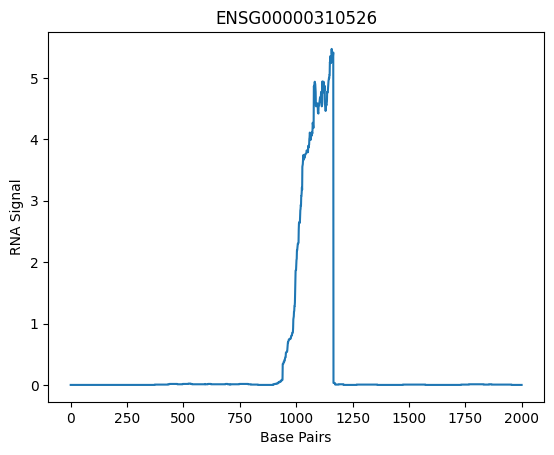

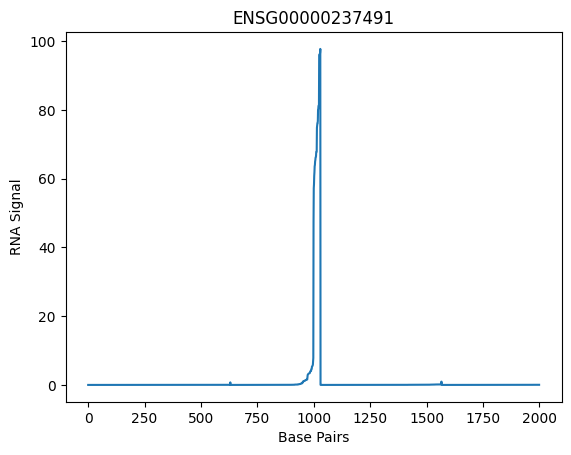

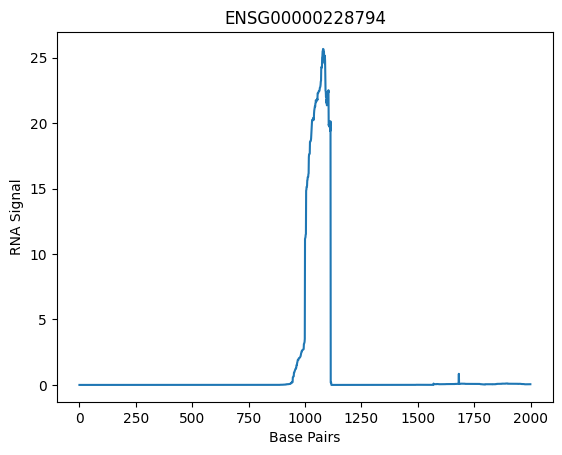

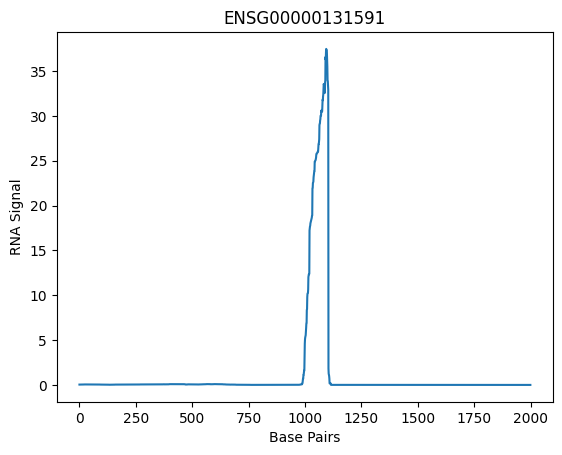

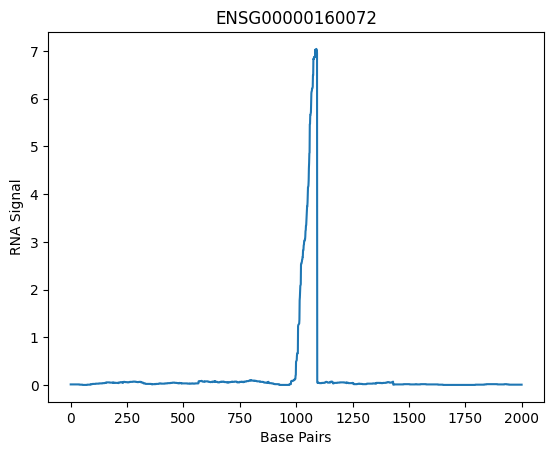

Threshold: 4.5
Number of Genes w/ Strong Peaks: 188


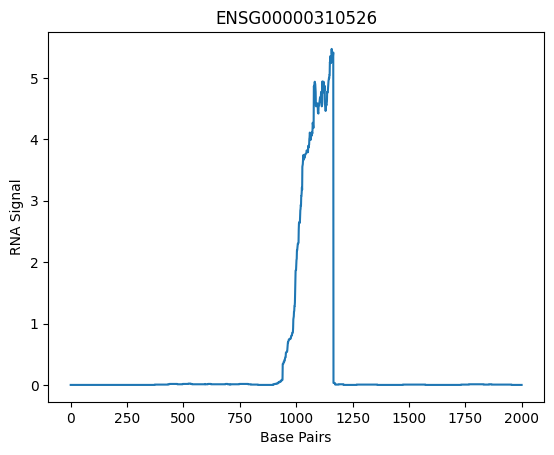

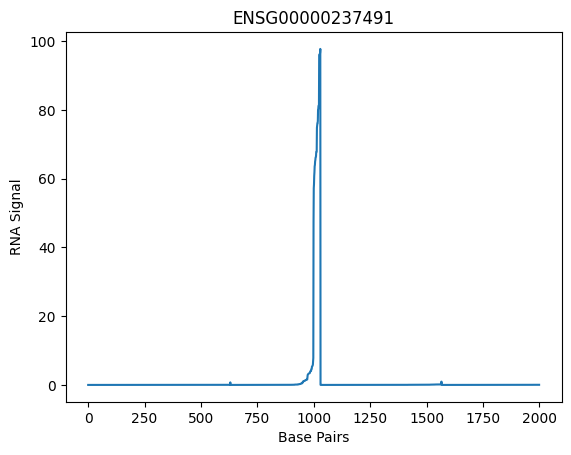

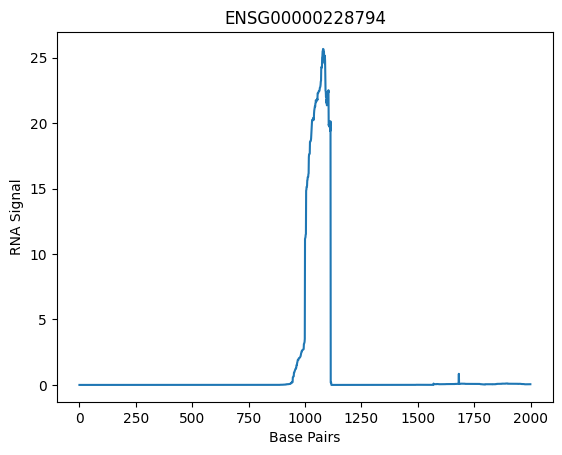

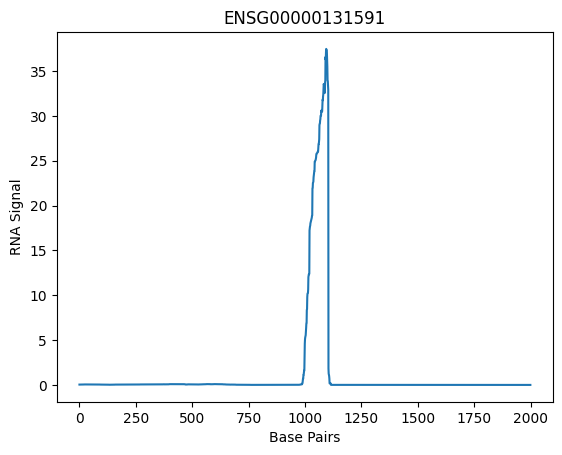

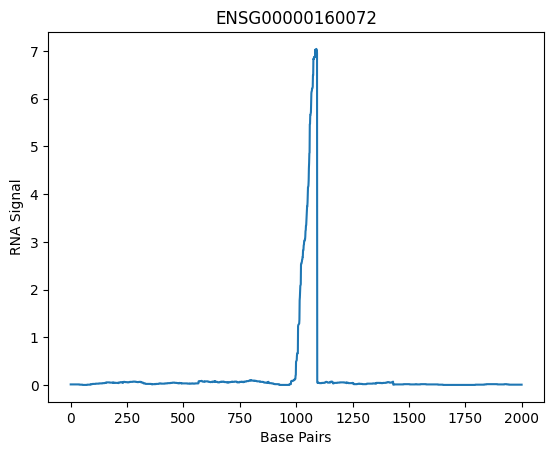

Threshold: 5.0
Number of Genes w/ Strong Peaks: 174


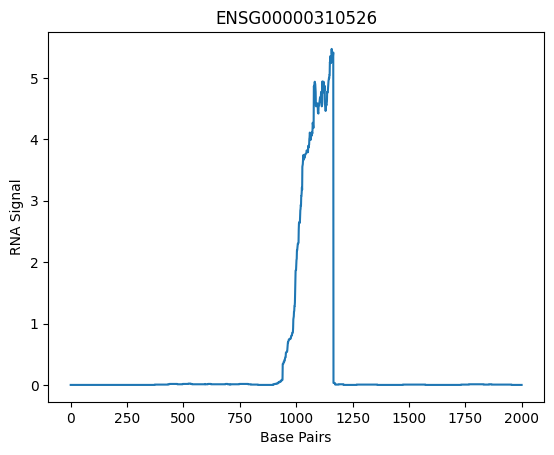

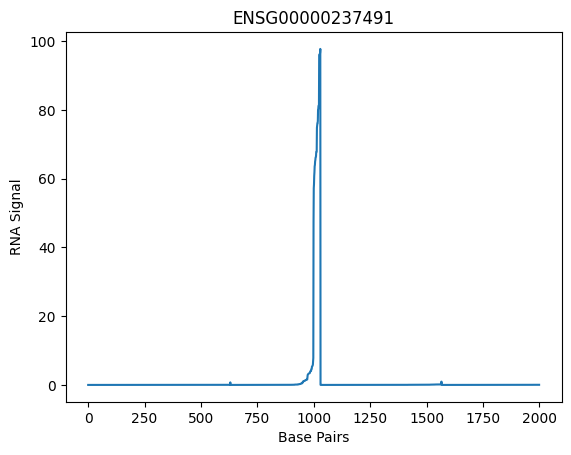

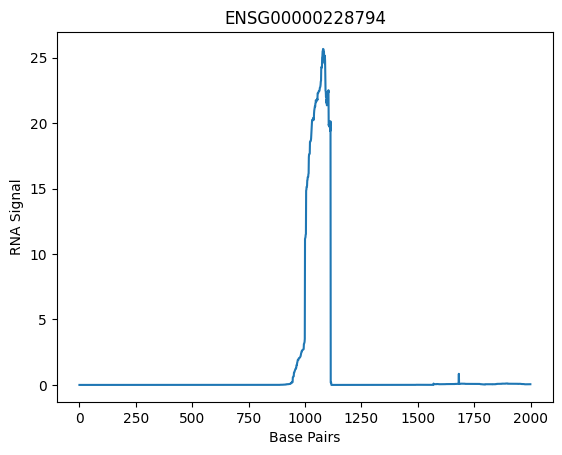

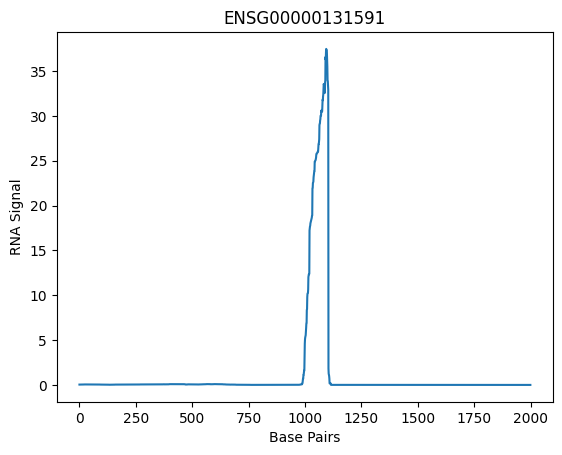

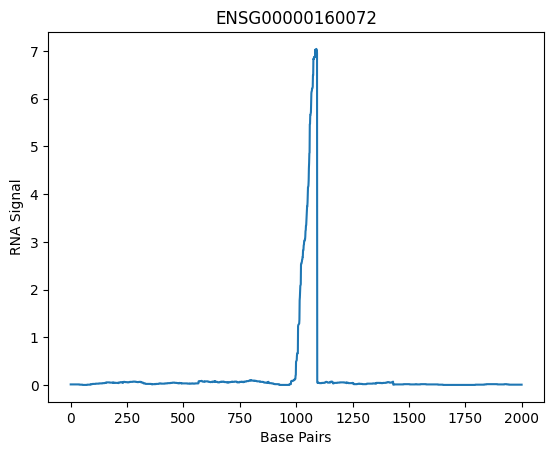

In [38]:
# K562
thresholds = np.linspace(0, 5, 11)
bool_df = [gene.decode() in list(fp_k5["ENSID"]) for gene in k5_h5["ensid"]]
rna = k5_h5["rna"][:][bool_df]
ensid = k5_h5["ensid"][:][bool_df]

peak_counts = []
for threshold in thresholds:
    peak = [ensid[idx].decode() for idx, sig in enumerate(rna) if np.max(sig) in sig[808:1192] and np.max(sig) > threshold]
    peak_bool = [gene.decode() in peak for gene in k5_h5["ensid"]]

    peak_counts.append(sum(peak_bool))
    print(f"Threshold: {threshold}\nNumber of Genes w/ Strong Peaks: {sum(peak_bool)}")
    for idx, gene in enumerate(k5_h5["rna"][:][peak_bool][0:5]):
        plt.title(ensid[idx].decode())
        plt.ylabel("RNA Signal")
        plt.xlabel("Base Pairs")
        plt.plot(gene)
        plt.show()

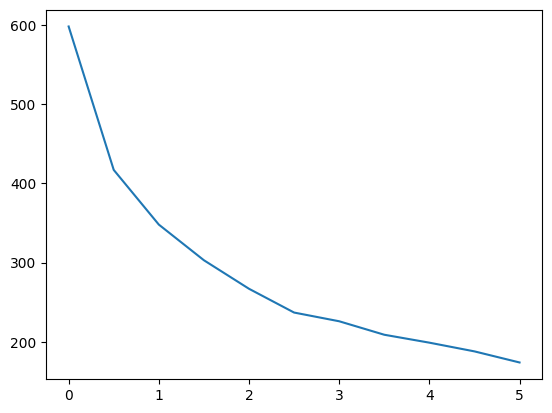

In [39]:
plt.plot(thresholds, peak_counts)

Aggregate Plots of Best Predictions

Threshold: 0.02, with 668 genes.


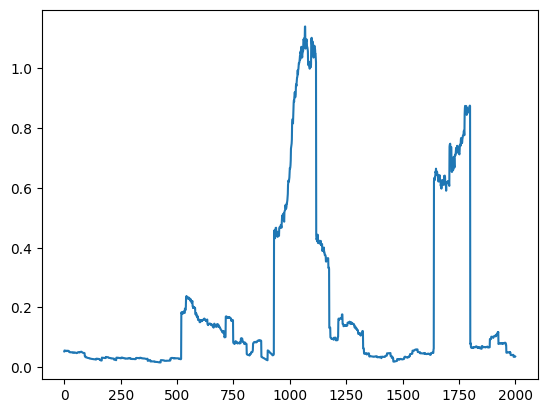

Threshold: 0.039999999999999994, with 1383 genes.


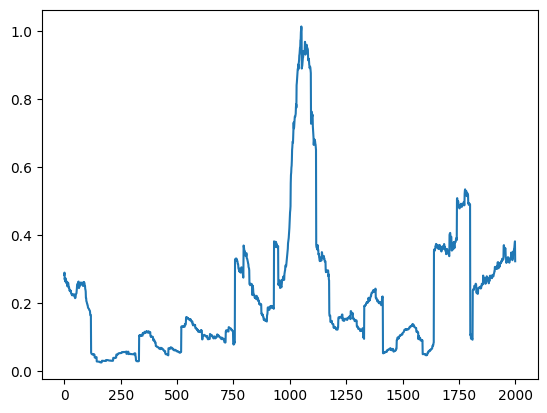

Threshold: 0.06, with 2223 genes.


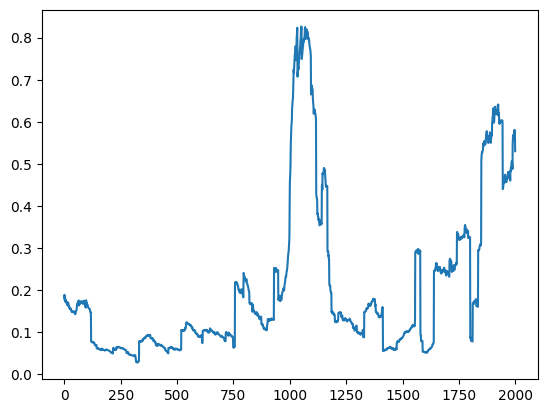

Threshold: 0.07999999999999999, with 3118 genes.


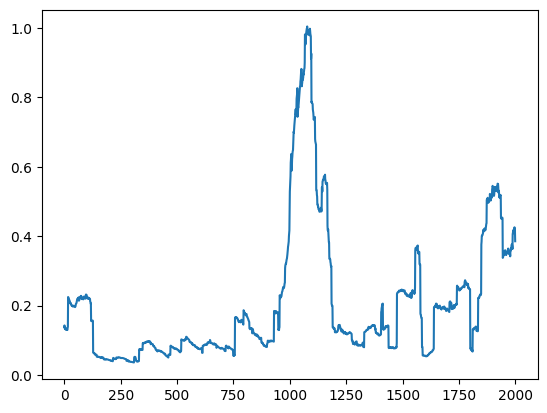

Threshold: 0.09999999999999999, with 4133 genes.


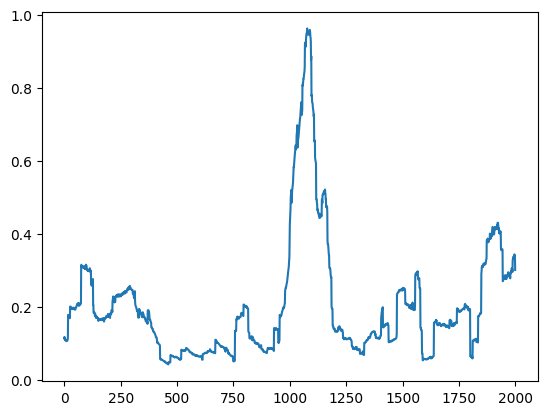

Threshold: 0.11999999999999998, with 5175 genes.


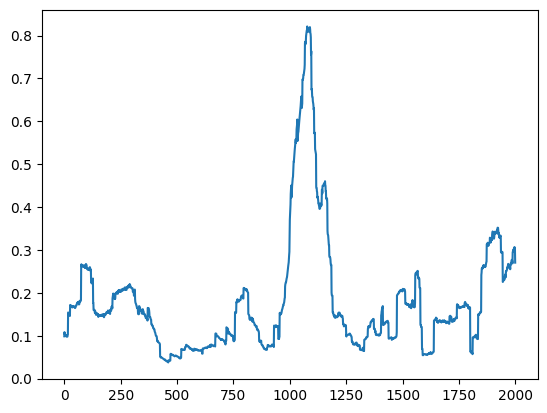

Threshold: 0.13999999999999999, with 6180 genes.


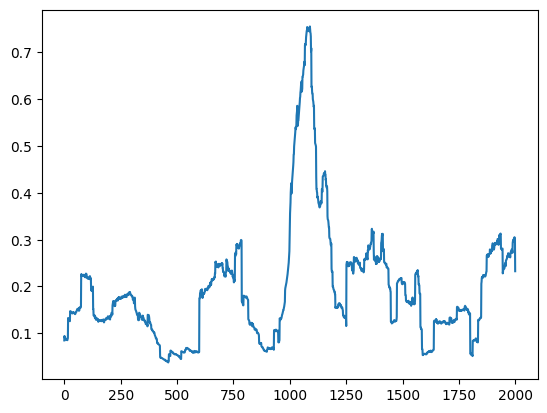

Threshold: 0.15999999999999998, with 7146 genes.


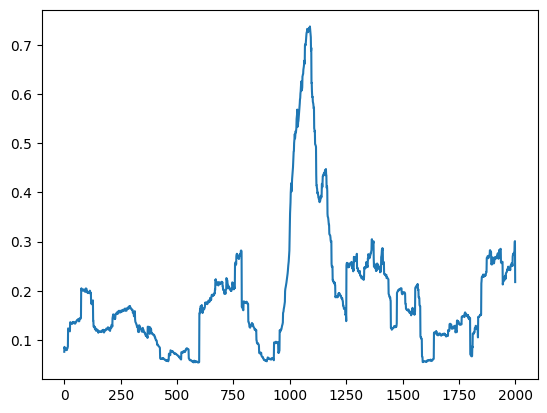

Threshold: 0.17999999999999997, with 8180 genes.


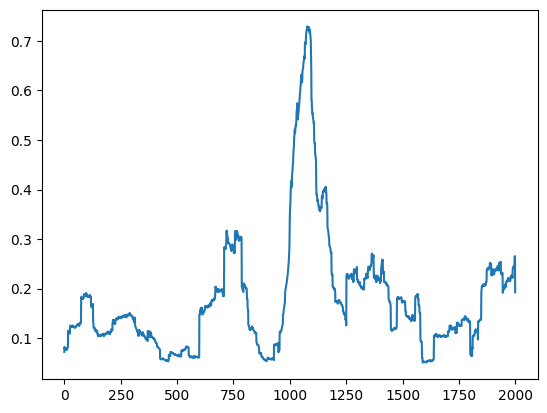

Threshold: 0.19999999999999996, with 9123 genes.


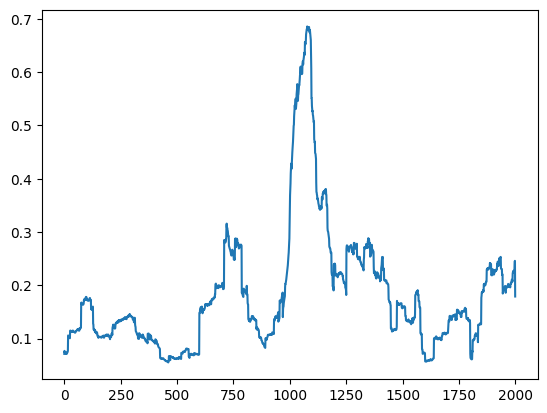

Threshold: 0.21999999999999995, with 9999 genes.


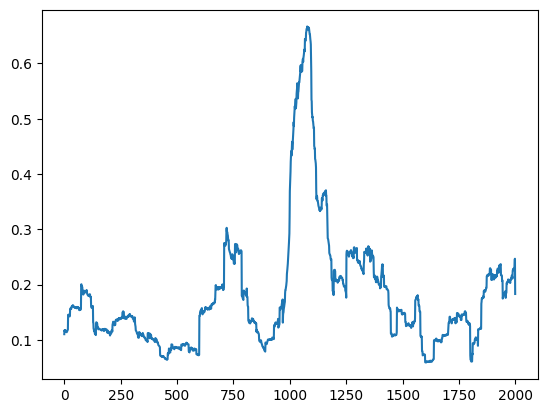

Threshold: 0.23999999999999996, with 10910 genes.


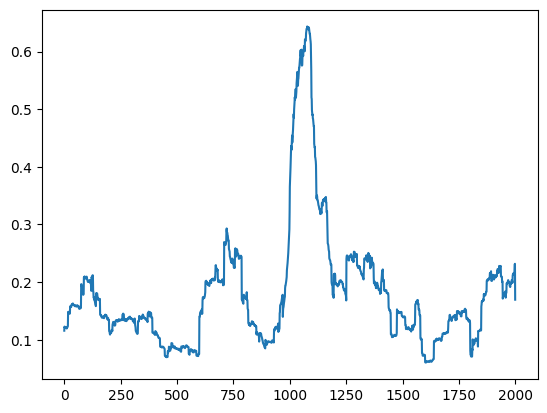

Threshold: 0.25999999999999995, with 11706 genes.


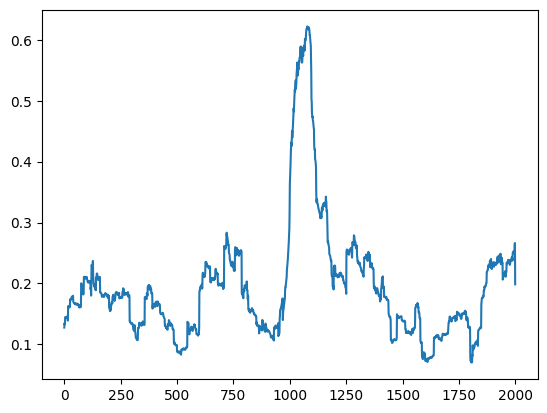

Threshold: 0.27999999999999997, with 12499 genes.


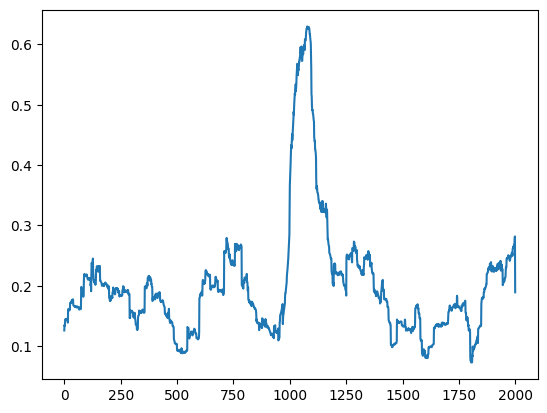

Threshold: 0.3, with 13219 genes.


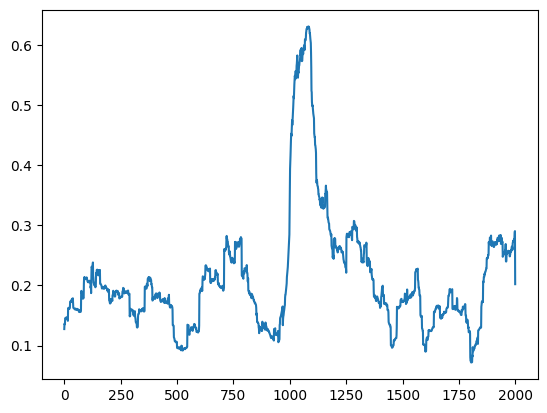

In [40]:
# GM12878
counts = []
thresholds = np.linspace(0.02, 0.3, 15)
for threshold in thresholds:
    best_gm = gm[gm["Error"] < threshold]

    bool_df = [gene.decode() in list(best_gm["Unnamed: 0"]) for gene in gm_h5["ensid"]]
    ensid = gm_h5["ensid"][:][bool_df]
    rna = gm_h5["rna"][:][bool_df]

    counts.append(len(rna))
    print(f"Threshold: {threshold}, with {len(rna)} genes.")
    plt.plot(np.mean(rna, axis=0))
    plt.show()


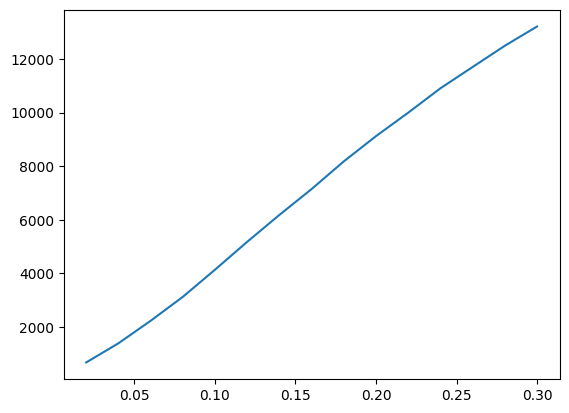

In [41]:
plt.plot(thresholds, counts)

Threshold: 0.01, with 348 genes.


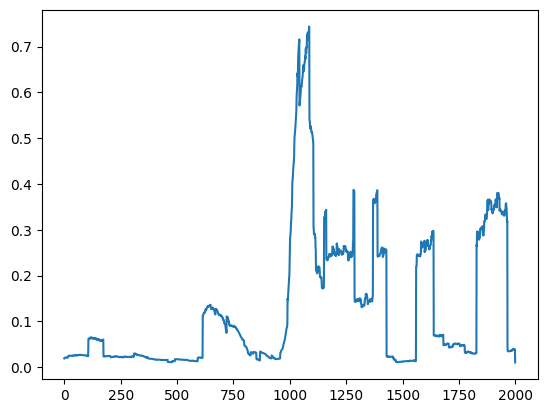

Threshold: 0.02, with 720 genes.


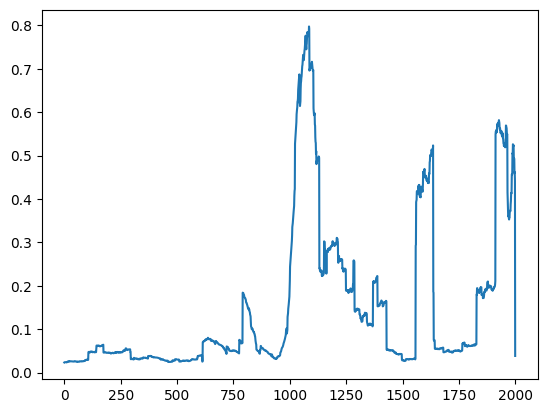

Threshold: 0.03, with 1213 genes.


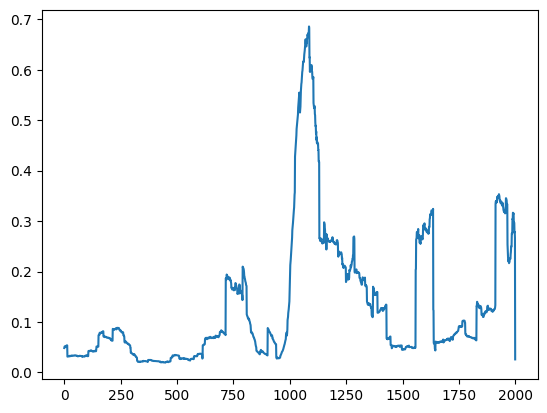

Threshold: 0.04, with 1711 genes.


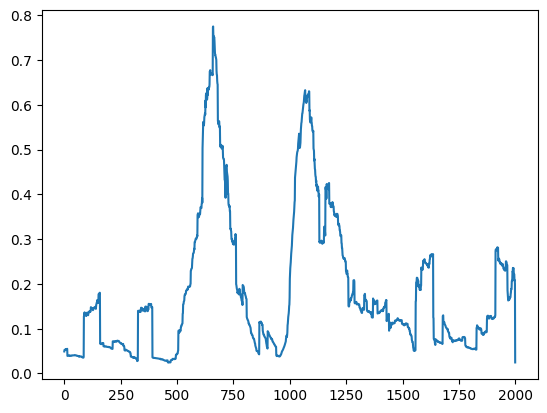

Threshold: 0.05, with 2235 genes.


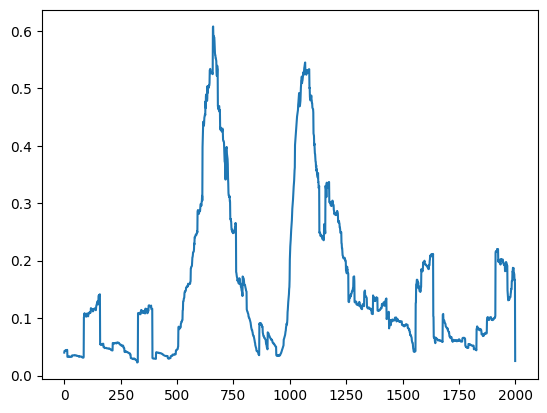

In [42]:
# K562
counts = []
thresholds = np.linspace(0.01, 0.05, 5)
for threshold in thresholds:
    best_k5 = k5[k5["Error"] < threshold]

    bool_df = [gene.decode() in list(best_k5["Unnamed: 0"]) for gene in k5_h5["ensid"]]
    ensid = k5_h5["ensid"][:][bool_df]
    rna = k5_h5["rna"][:][bool_df]

    print(f"Threshold: {threshold}, with {len(rna)} genes.")
    counts.append(len(rna))
    plt.plot(np.mean(rna, axis=0))
    plt.show()

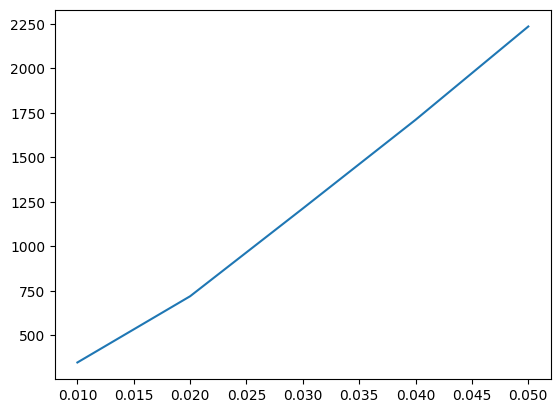

In [43]:
plt.plot(thresholds, counts)

List of Genes for K562 (Error < 0.01)

In [44]:
# k5[k5["Error"] < 0.01]["Unnamed: 0"].to_csv("k562.001.txt", header=False, index=None, sep=" ")

List of Genes for K562 (Set Difference Between Error < 0.03 and Error < 0.04)

In [45]:
# k5_003 = k5[k5["Error"] < 0.03]["Unnamed: 0"]
# k5_004 = k5[k5["Error"] < 0.04]["Unnamed: 0"]

In [46]:
# diff_003_004 = k5_004[~k5_004.isin(k5_003)]
# k5_004[~k5_004.isin(k5_003)].to_csv("k562.003_004_diff.txt", header=False, index=None, sep=" ")

Identify Outliers in the Set Difference

In [47]:
# bool_df = [gene.decode() in list(diff_003_004) for gene in k5_h5["ensid"]]
# rna = k5_h5["rna"][:][bool_df]
# ensid = k5_h5["ensid"][:][bool_df]

In [48]:
# with open("k5_003_004_outliers.txt", "a") as file:
#     for idx, sig in enumerate(rna):
#         if np.max(sig) > 1 and np.max(sig) in sig[450:900]:
#             file.write(f"{ensid[idx].decode()}\n")

        